# Utils

In [370]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [20, 7]
import scipy.stats as sts
import glob
from collections import defaultdict


def plot_data(path, key='VanillaAvgRet'):
    xlabel='Iteration'
    df = pd.read_csv(path)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    fig.suptitle(key)
    mean = df[key]
    ax.plot(df[xlabel], mean)
    return fig


In [483]:
def plot_data(path, key='ReturnLastEpisode'):
    df = pd.read_csv(path)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    mean = df[key]
    ax.plot(df['Iteration'], mean)
    return fig

def plot_all(dfs, key='AvgRet', ylim=None, scale='Samples'):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    for df in dfs:
        value = df[key]
        ax.plot(df[scale+'SoFar'], value)
    return fig

def compare(candidates, conf=0.95, key='AvgRet', ylim=None, xlim=None, scale='Eps'):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    entries = []
    for candidate_name in candidates:
        entries.append(candidate_name)
        dfs = candidates[candidate_name]
        n_runs = len(dfs)
        mean_df, std_df = moments(dfs)
        mean = mean_df[key]
        std = std_df[key]
        ax.plot(mean_df[scale], mean)
        interval = sts.t.interval(conf, n_runs-1,loc=mean,scale=std/np.sqrt(n_runs))
        ax.fill_between(mean_df[scale+'SoFar'], interval[0], interval[1], alpha=0.3)
        print(candidate_name, end=': ')
        print_ci(dfs, conf)
    ax.legend(entries, loc='upper left')
    if ylim: ax.set_ylim(ylim)
    if xlim: ax.set_xlim(xlim)
    return fig

def compare_2(means, stds, conf, ylim=None):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    for mean, std in zip(means, stds):
        n_runs = len(mean)
        ax.plot(mean.index, mean)
        interval = sts.t.interval(conf, n_runs-1,loc=mean,scale=std/np.sqrt(n_runs))
        ax.fill_between(mean.index, interval[0], interval[1], alpha=0.3)
    if ylim: ax.set_ylim(ylim)
    ax.legend(bounds)
    return fig

# Calculate, plot and save confidence intervals

def moments(dfs):
    concat_df = pd.concat(dfs, axis=1)
    mean_df = pd.concat(dfs, axis=1).groupby(by=concat_df.columns, axis=1).mean()
    std_df = pd.concat(dfs, axis=1).groupby(by=concat_df.columns, axis=1).std()
    return mean_df, std_df

def plot_ci(dfs, conf=0.95, key='ReturnLastEpisode', ylim=None, scale='Iteration', title=None):
    n_runs = len(dfs)
    mean_df, std_df = moments(dfs)
    mean = mean_df[key]
    std = std_df[key]
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(mean_df[scale], mean)
    interval = sts.t.interval(conf, n_runs-1,loc=mean,scale=std/np.sqrt(n_runs))
    ax.fill_between(mean_df[scale], interval[0], interval[1], alpha=0.3)
    if ylim: ax.set_ylim(ylim)
    if title is None:
        title = key
    else:
        title = key + ' - ' + title
    ax.set_title(title)
    return fig

def print_ci(dfs, conf=0.95, key='ReturnLastEpisode'):
    n_runs = len(dfs)
    mean_df, std_df = moments(dfs)
    total_horizon = len(mean_df)
    mean = mean_df[key][len(mean_df)-1]
    std = std_df[key][len(mean_df)-1]
    interval = sts.t.interval(conf, n_runs-1,loc=mean,scale=std/np.sqrt(n_runs))
    print('%f \u00B1 %f\t[%f, %f]\t total horizon: %d' % (mean, std, interval[0], interval[1], int(total_horizon)))

def save_ci(dfs, conf=0.95, key='ReturnLastEpisode', ylim=None, scale='Iteration', horizon=1000, filename='prova.csv'):
    n_runs = len(dfs)
    mean_df, std_df = moments(dfs)
    mean = mean_df[key]
    std = std_df[key]
    interval = sts.t.interval(conf, n_runs-1,loc=mean,scale=std/np.sqrt(n_runs))
    low = pd.Series(interval[0])
    high = pd.Series(interval[1])
    iteration = pd.Series(horizon*np.array(range(len(mean))))
    df_out = pd.DataFrame(list(zip(iteration, mean, std, low, high)), columns=['iteration', 'mean', 'std', 'low', 'up'])
    df_out.to_csv(filename, index=False)


In [484]:
def read_csv(path, substrings, max_iters=None):
    
    # Getting a list of relevant filenames
    filenames = glob.glob(path)
    if substrings is not None:
        for substring in substrings:
            filenames = [f for f in filenames if substring in f ]
    # Turning them into dfs, dropping non-numeric columns
    dfs_list = [pd.read_csv(filename).select_dtypes(['number']) for filename in filenames]
    # Make sure that all dfs have the same number of trajectories
    if max_iters is not None:
        dfs_list = [df[:max_iters] for df in dfs_list]
    return dfs_list, filenames
    
    
def create_average_df(path, substrings=None, max_iters=None, kpis=None):
    
    dfs_list, filenames = read_csv(path, substrings, max_iters)
    # Adding the filename to each dataframe
    for df, filename in zip(dfs_list, filenames):
      df['Filename'] = filename
    # Combine the list of dataframes, on top of each other
    combo_df = pd.concat(dfs_list, ignore_index=True, sort=False)
    if kpis is None:
        # Set kpis equal to the list of column names except 'Filename'
        kpis = combo_df.columns[:-1]
    n_files = len(filenames)
    means = defaultdict(list)
    for kpi in kpis:
        for it in range(max_iters):
            means[kpi].append(np.array([combo_df[kpi][it + f*max_iters] for f in range(n_files)]).mean())
    df_out = pd.DataFrame.from_dict(means)
    return df_out, filenames, combo_df, dfs_list

def extract_float(s):
    # Extract numbers from garbage string:
    newstr = ''.join((ch if ch in '0123456789.-e' else ' ') for ch in str(s))
    listOfNumbers = [float(i) for i in newstr.split()]
    listOfNumbers = listOfNumbers[0]
    return listOfNumbers

def clean_df(df, str_columns):
    # Transform string columns into floats if there is any 
    fu = lambda x: extract_float(x)
    for column in str_columns:
        df[column] = pd.Series(list(map(extract_float, df[column].astype(str).values)))
    return df

def clean_csv(path, str_columns):
    # Getting a list of relevant filenames
    filenames = glob.glob(path)
    # Turning them into dfs, dropping non-numeric columns
    dfs_list = [pd.read_csv(f) for f in filenames]
    for df, filename in zip(dfs_list, filenames):
        df = clean_df(df, str_columns)
        df.to_csv("{}".format(filename))
    return dfs_list

In [485]:
# Clean the datasets from strings which should be floats
# path = "./old_logs/which_dtheta/*"
# str_columns = ['LQGsigma', 'LQGmu01', 'LQGmu1']
# dl = clean_csv(path, str_columns)

# Step-size fissa

In this experiments we try to tune the step-size alpha for the LQG problem when it is fixed along every iteration:
- alpha = dtheta = [1, 0.5, 0.1, 0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001]
- delta = [0.1, 0.2, 0.99]
- seed = [0, 1, 2]

/home/lupol/.local/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1903: RuntimeWarning: invalid value encountered in greater
  cond0 = self._argcheck(*args) & (scale > 0) & (loc == loc)
/home/lupol/.local/lib/python3.5/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


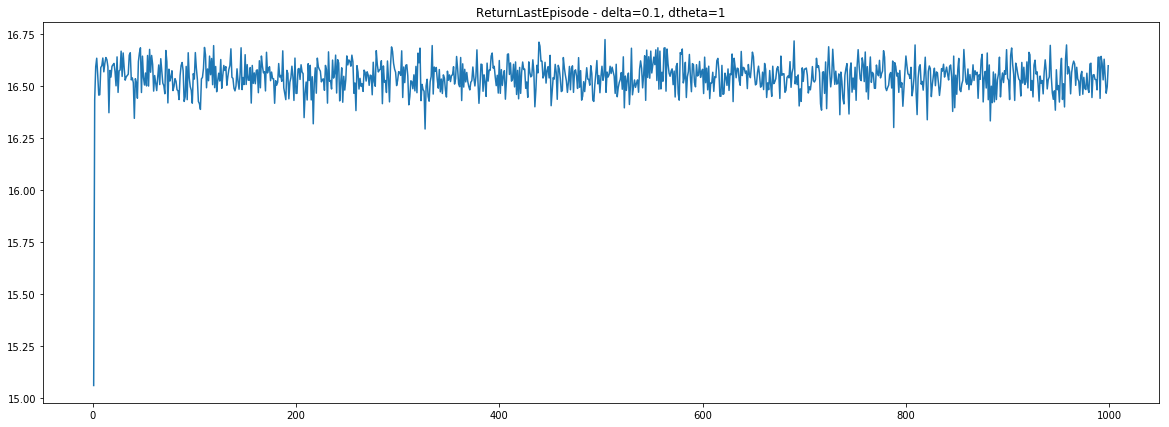

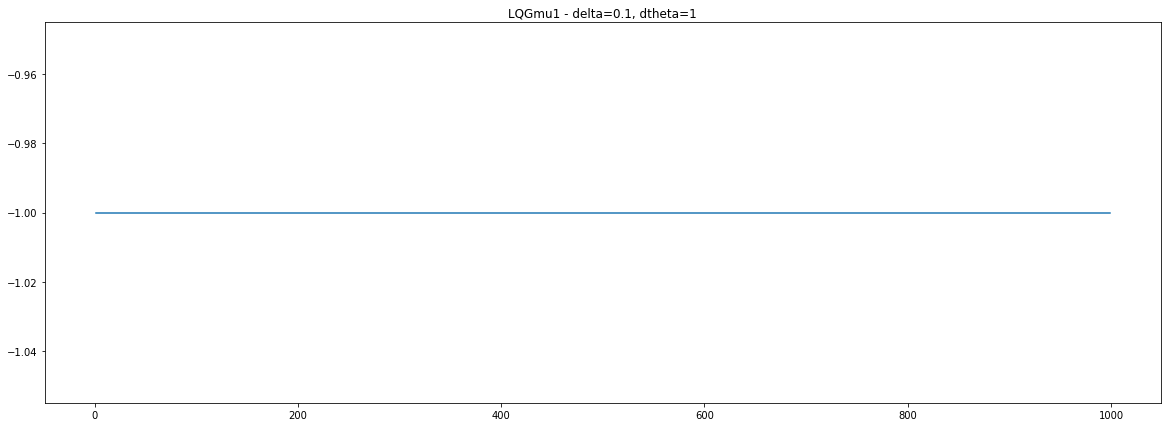

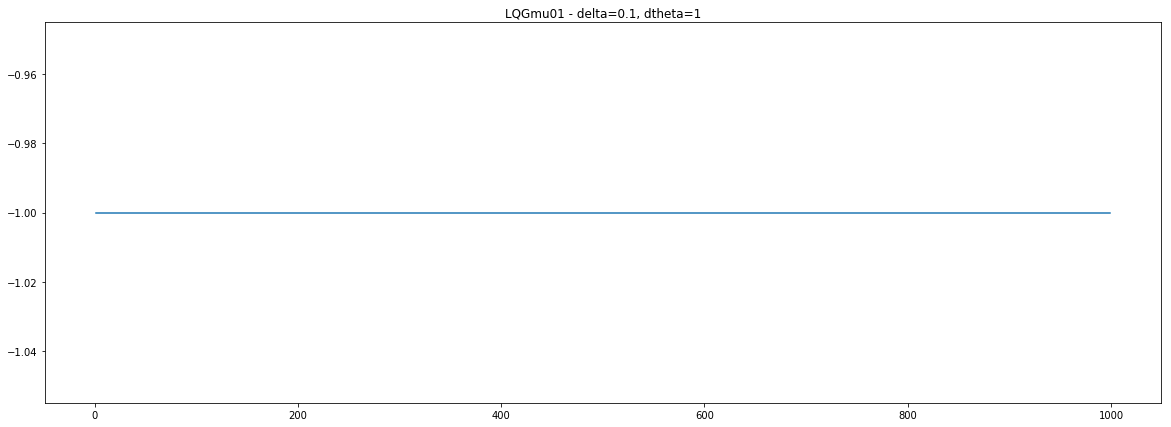

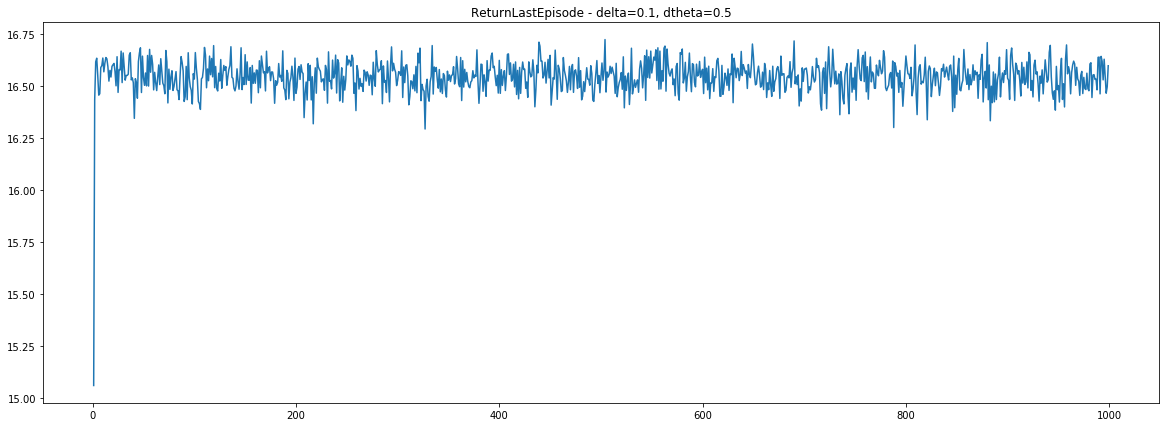

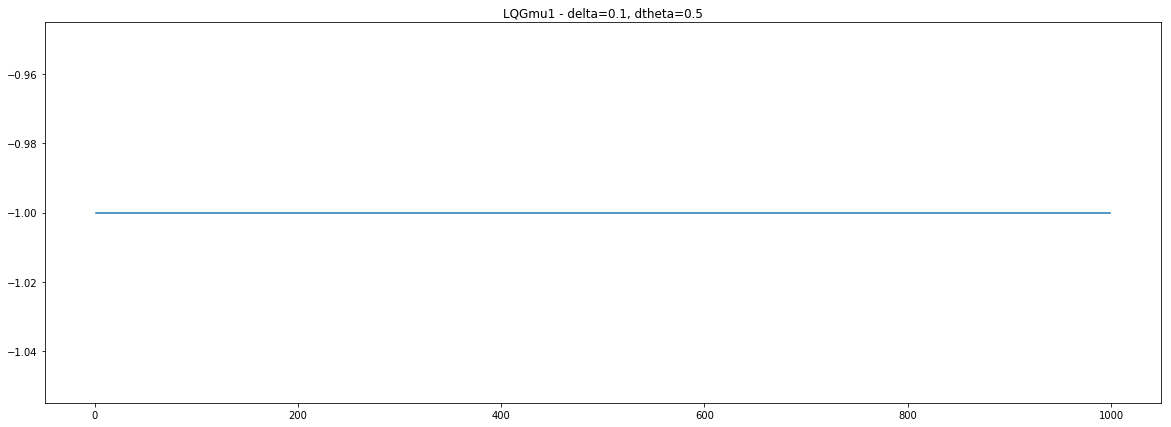

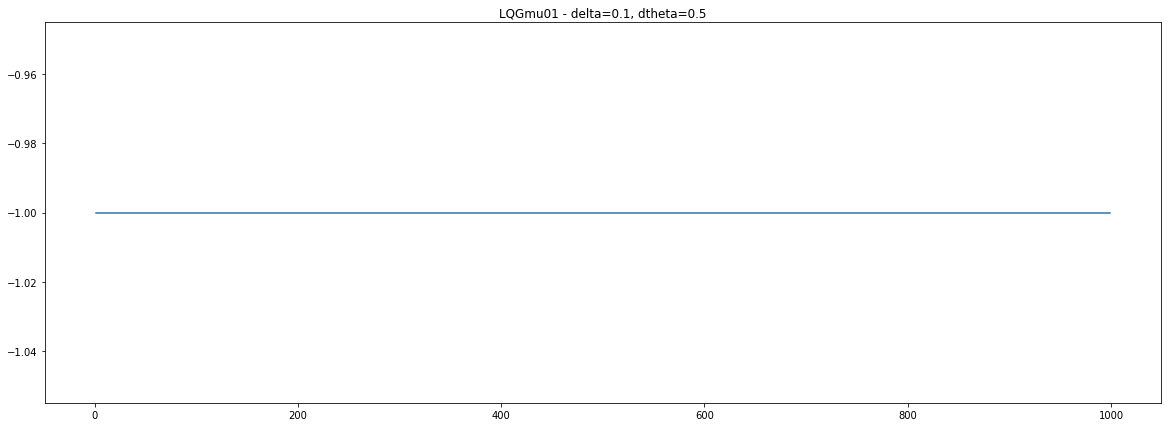

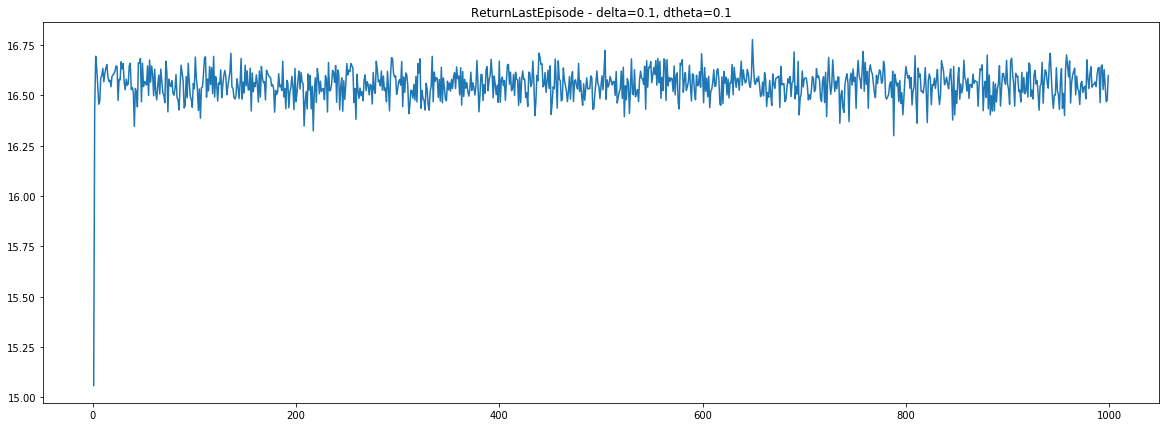

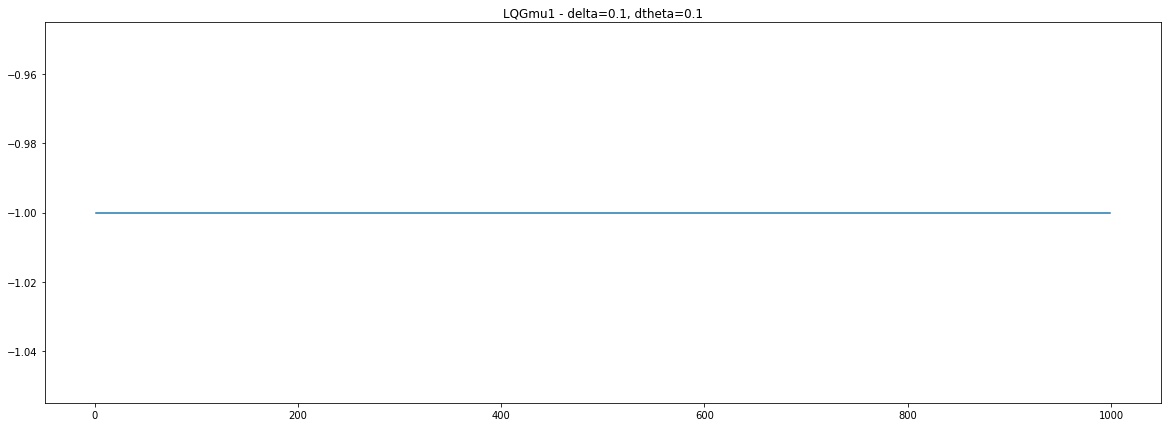

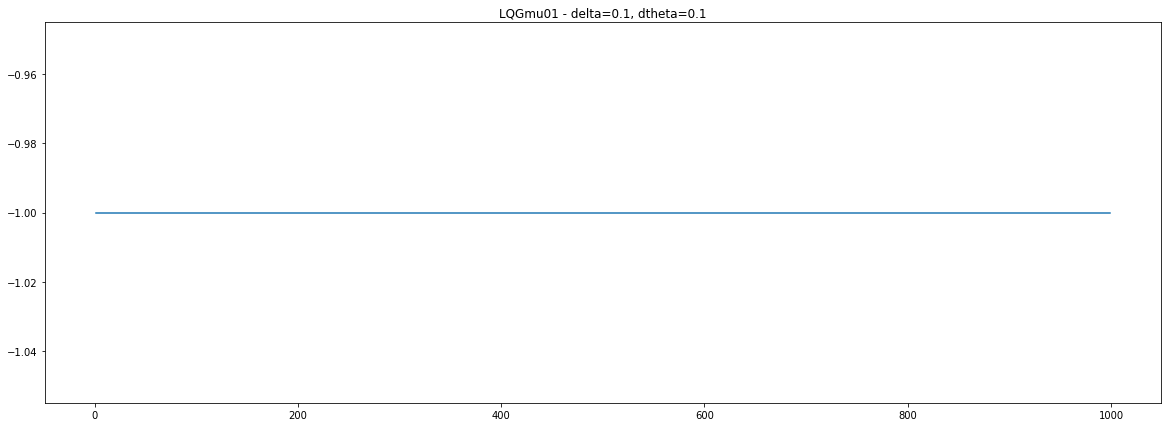

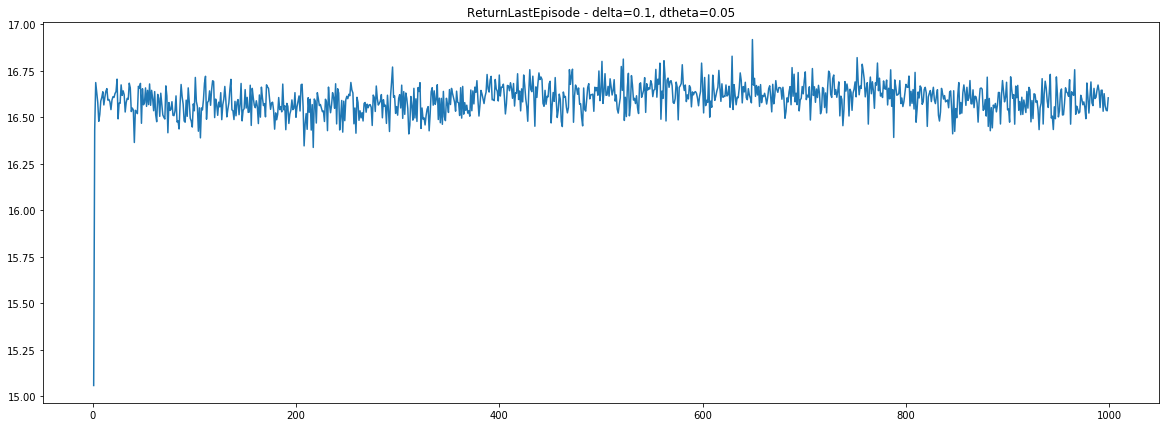

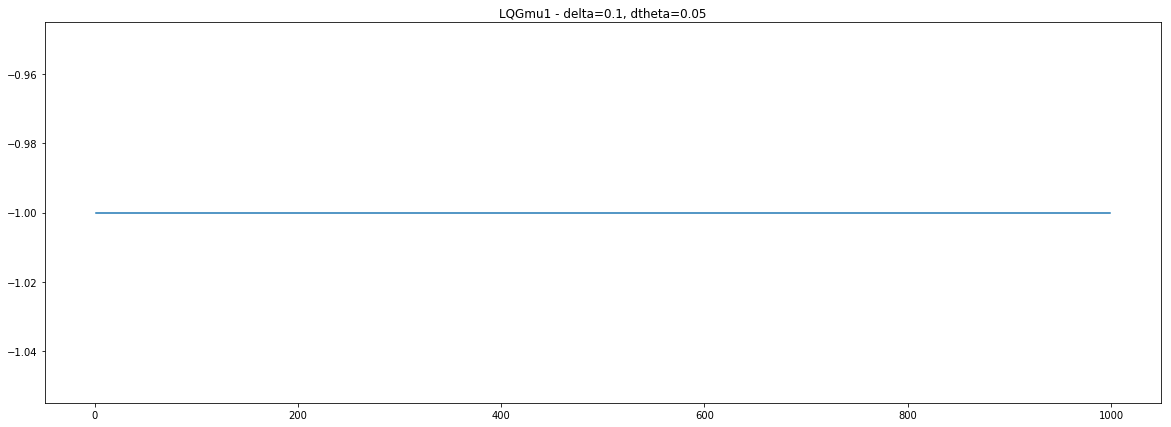

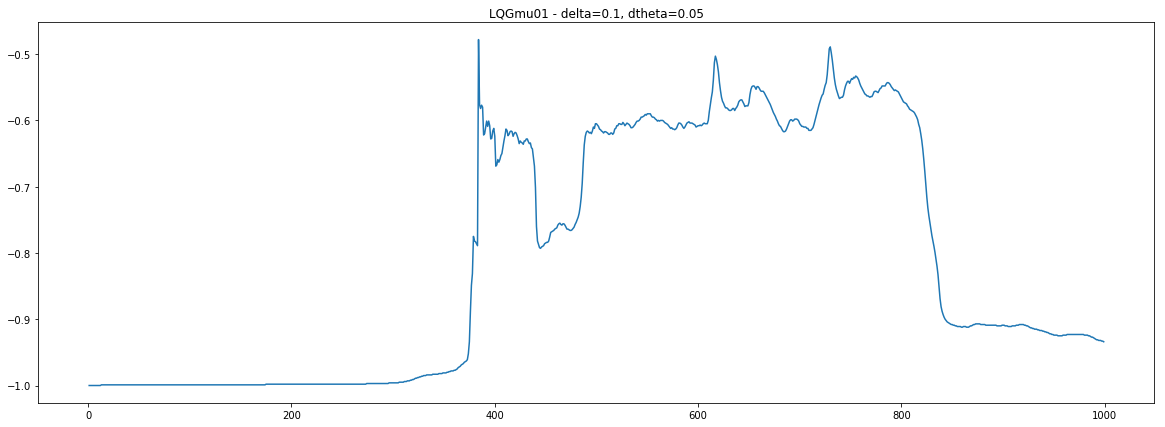

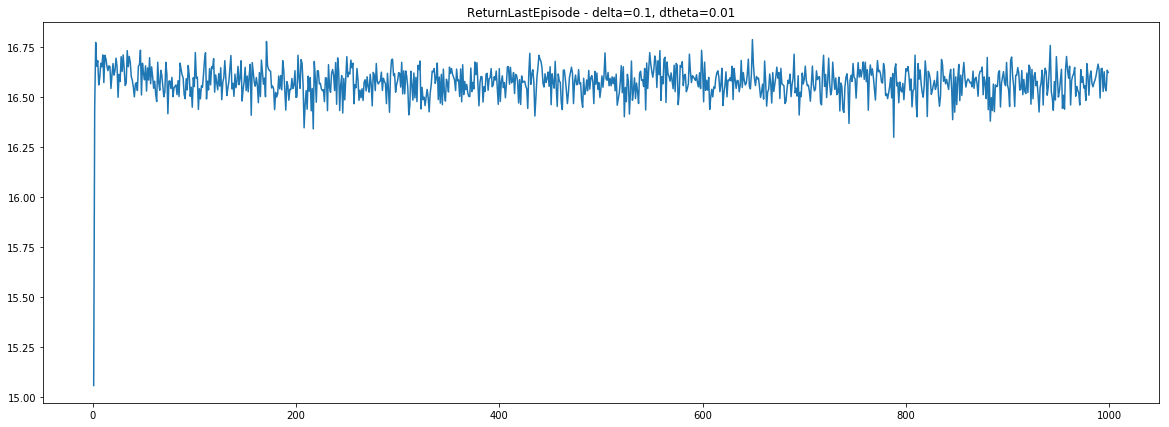

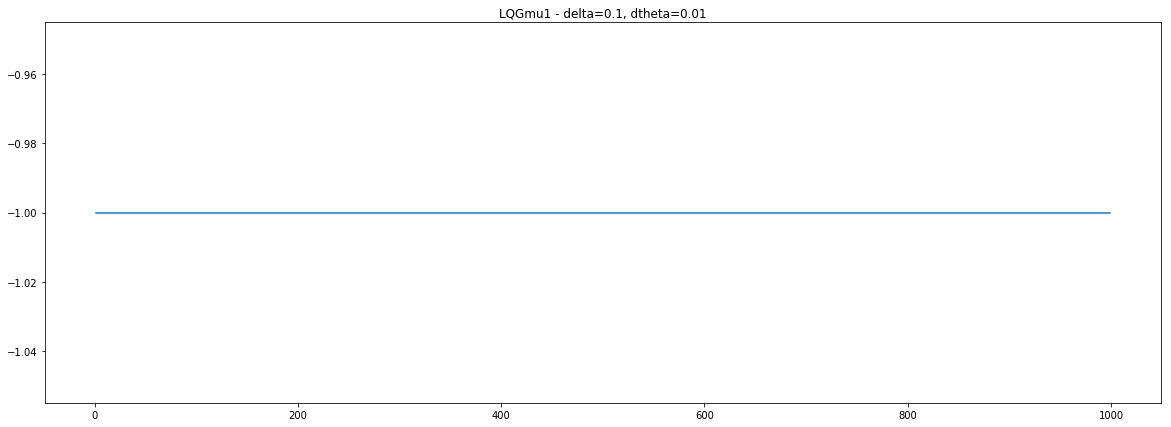

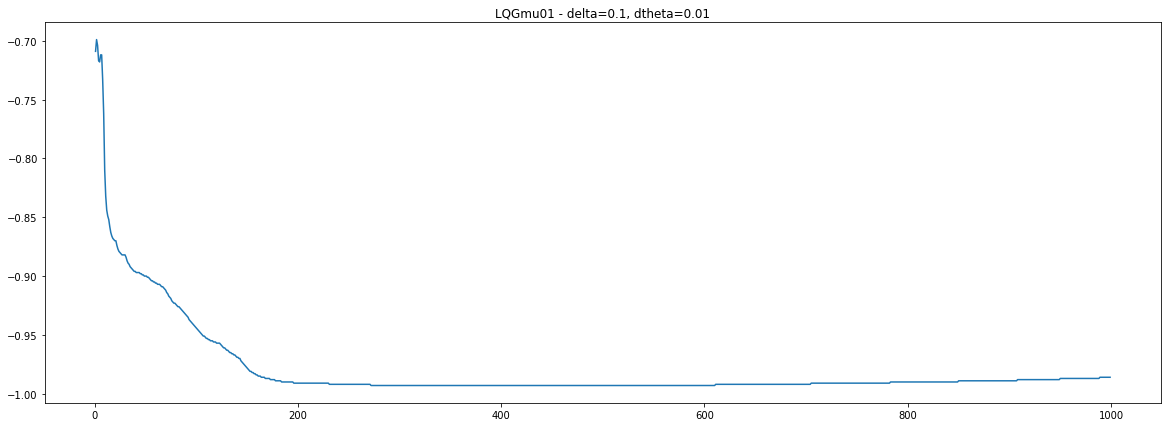

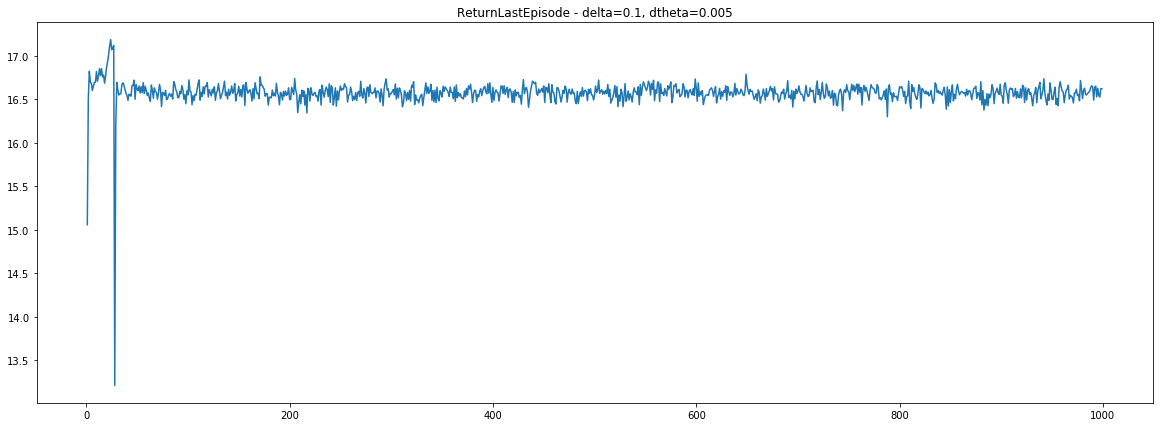

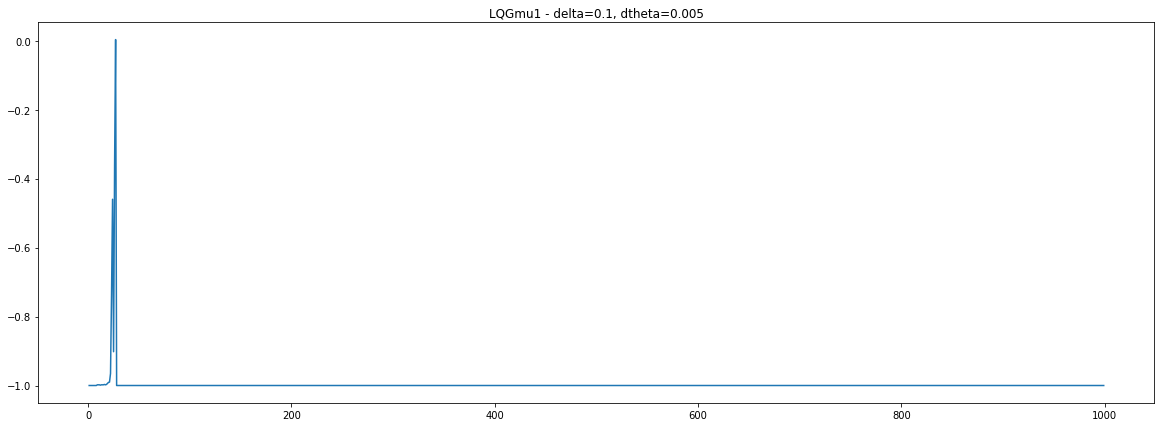

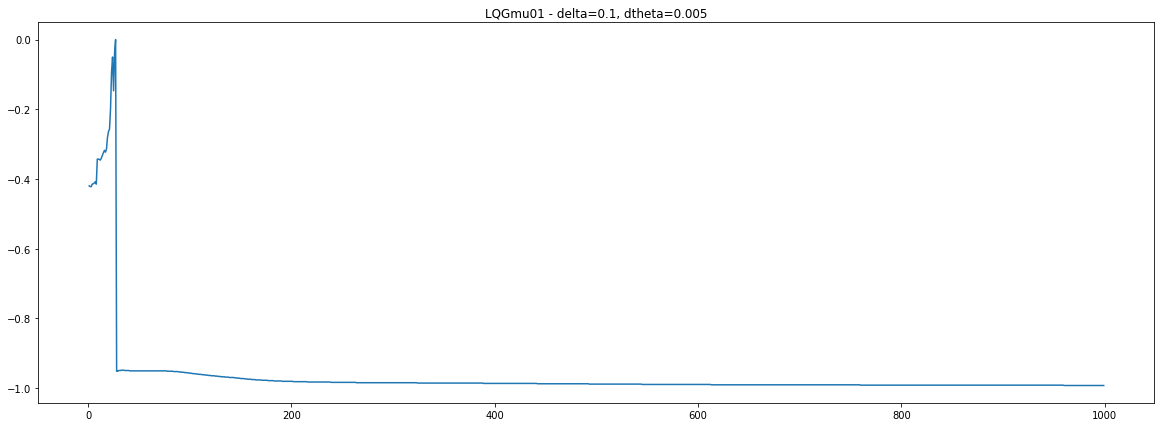

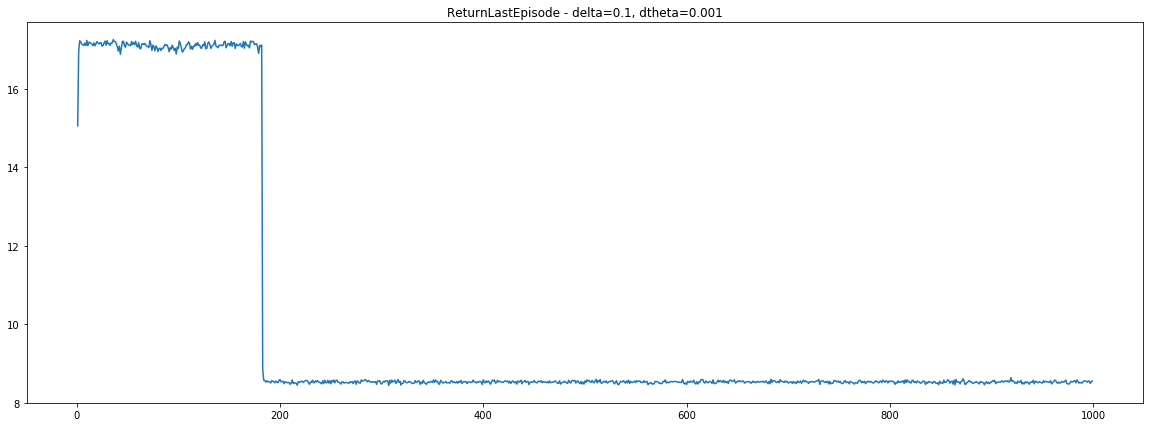

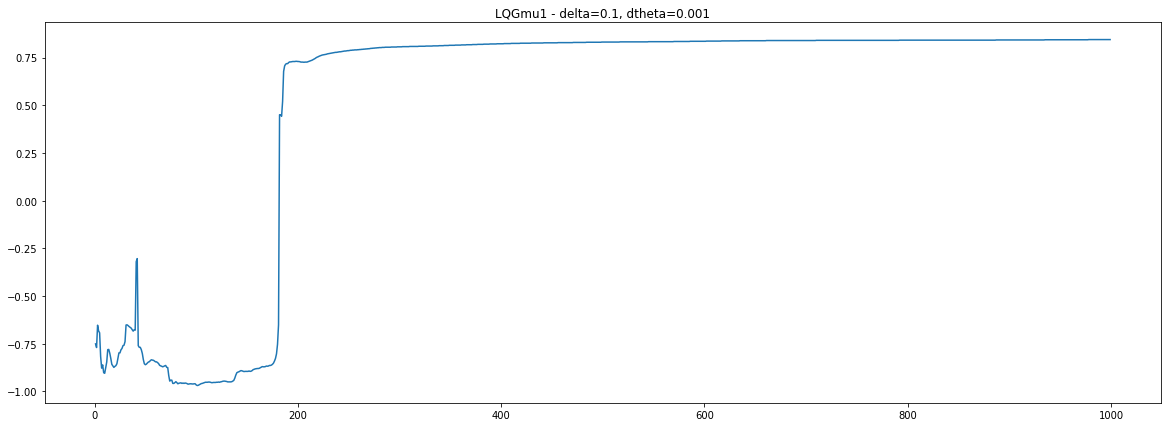

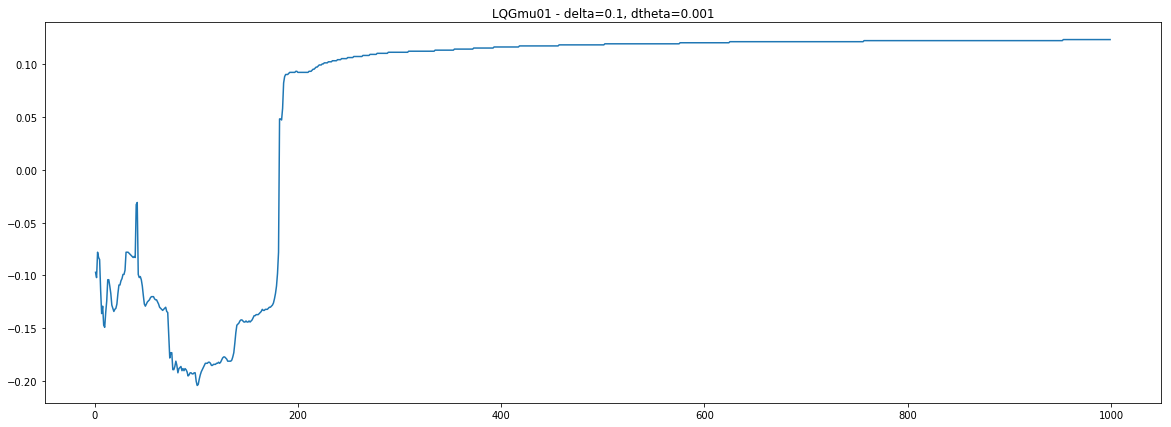

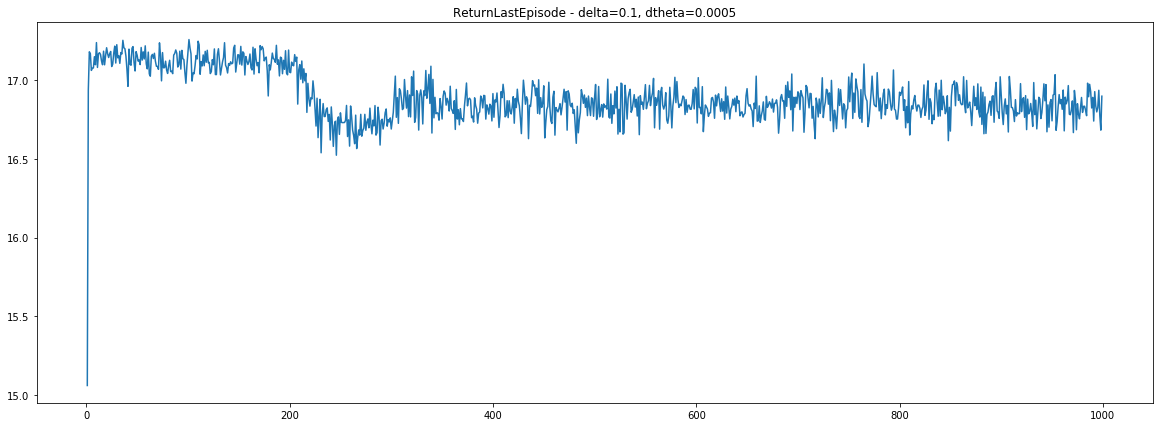

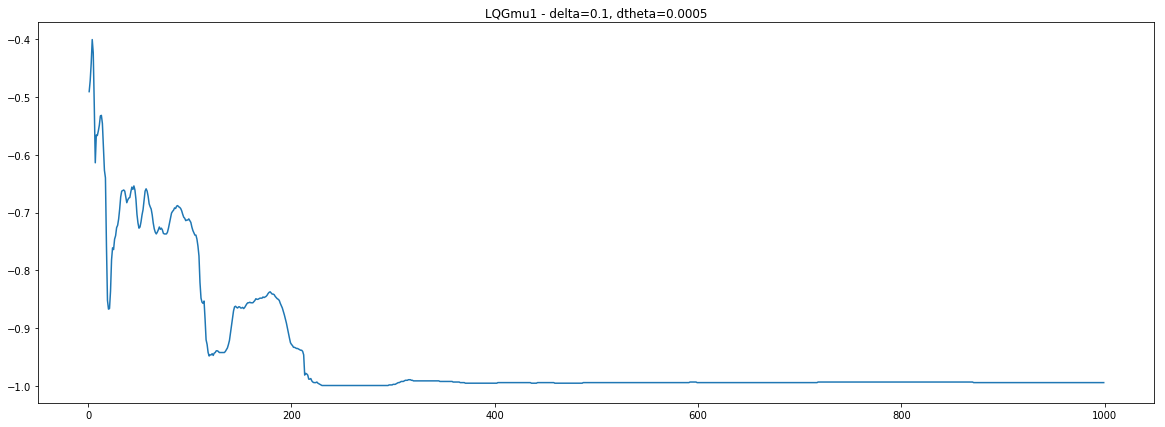

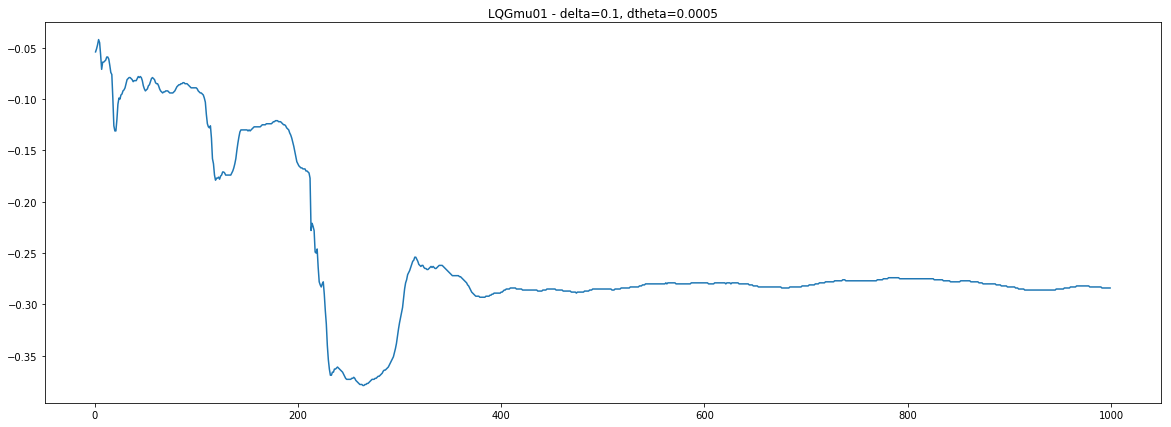

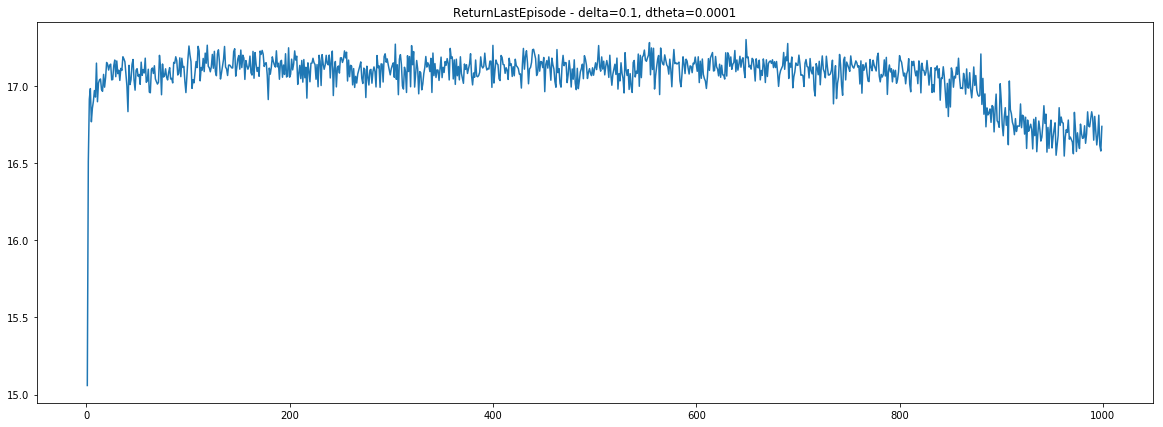

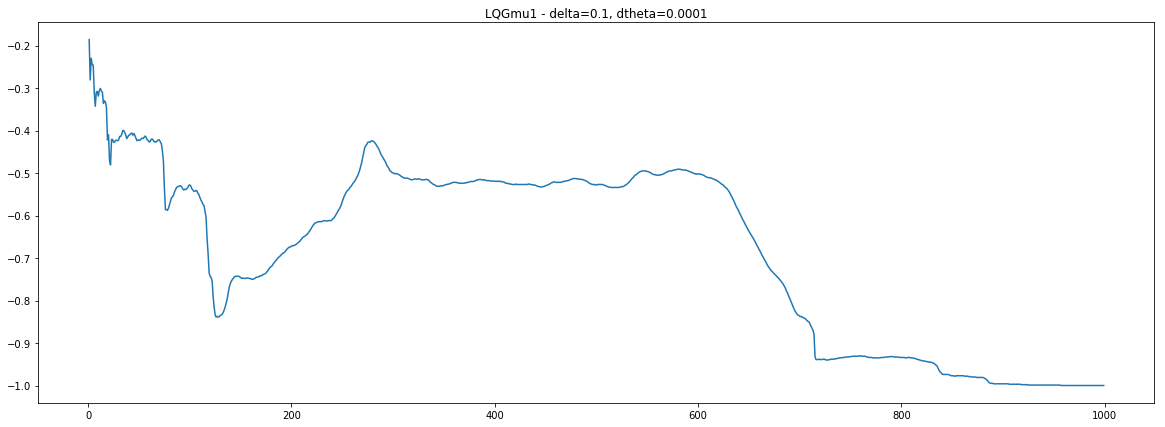

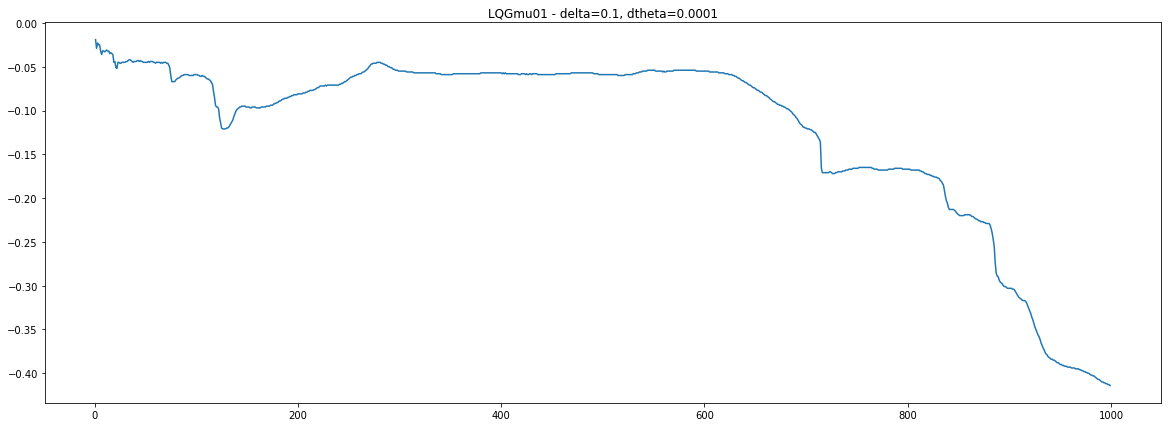

In [499]:
path ="./old_logs/which_dtheta/which_dtheta_fixed_*"
alpha = [1, 0.5, 0.1, 0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001]
delta = [0.1]
for d in delta:
    for a in alpha:
        substrings = ['delta=' + str(d), 'dtheta=' + str(a)] + ['seed=0'] # to check single seed
        dfs_list, filenames = read_csv(path, substrings, max_iters=None)
        tl = 'delta=' + str(d) + ', dtheta=' + str(a)
        fig1 = plot_ci(dfs_list, conf=0.95, key='ReturnLastEpisode', ylim=None, scale='Iteration', title=tl)
        fig2 = plot_ci(dfs_list, conf=0.95, key='LQGmu1', ylim=None, scale='Iteration', title=tl)
        fig3 = plot_ci(dfs_list, conf=0.95, key='LQGmu01', ylim=None, scale='Iteration', title=tl)


/home/lupol/.local/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1903: RuntimeWarning: invalid value encountered in greater
  cond0 = self._argcheck(*args) & (scale > 0) & (loc == loc)
/home/lupol/.local/lib/python3.5/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


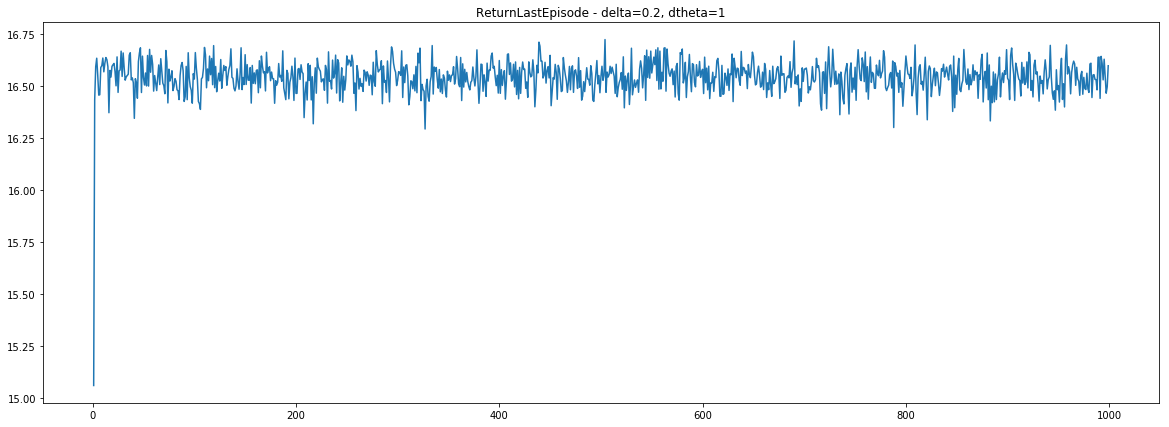

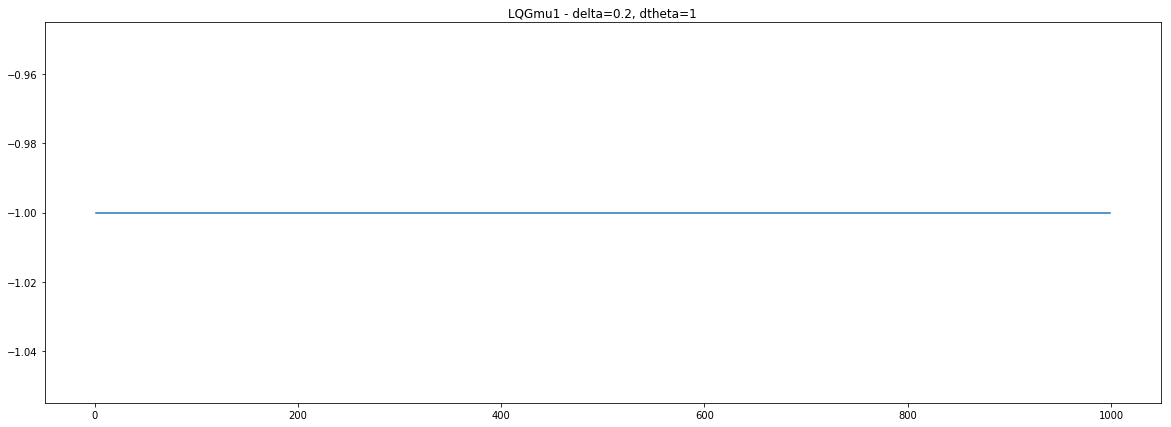

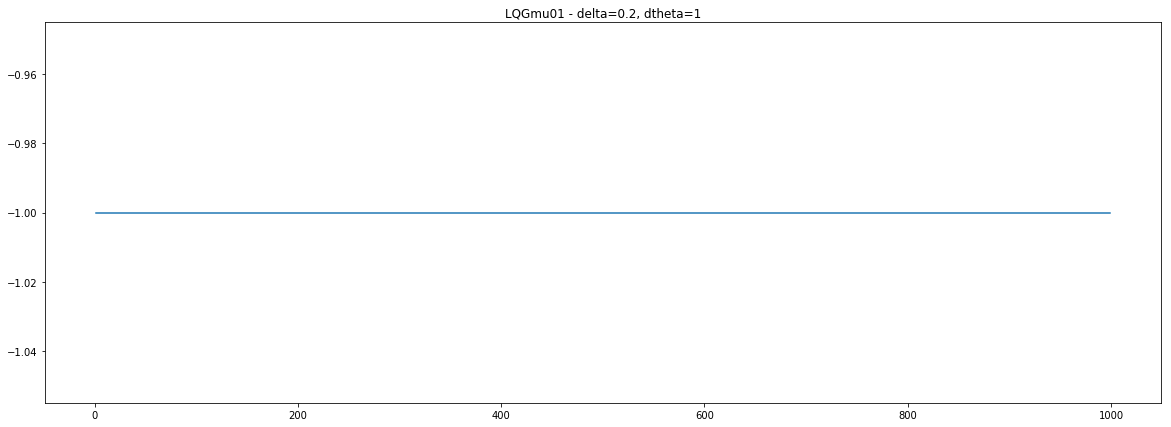

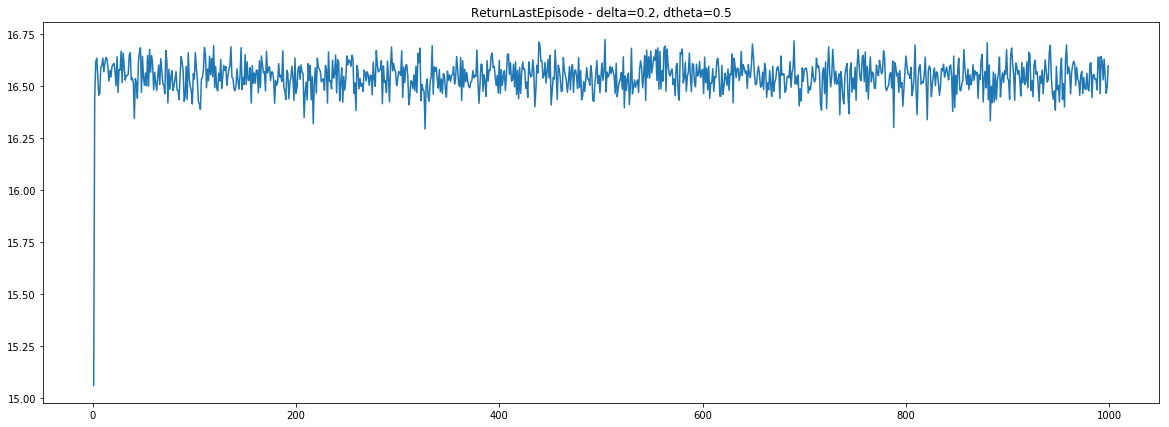

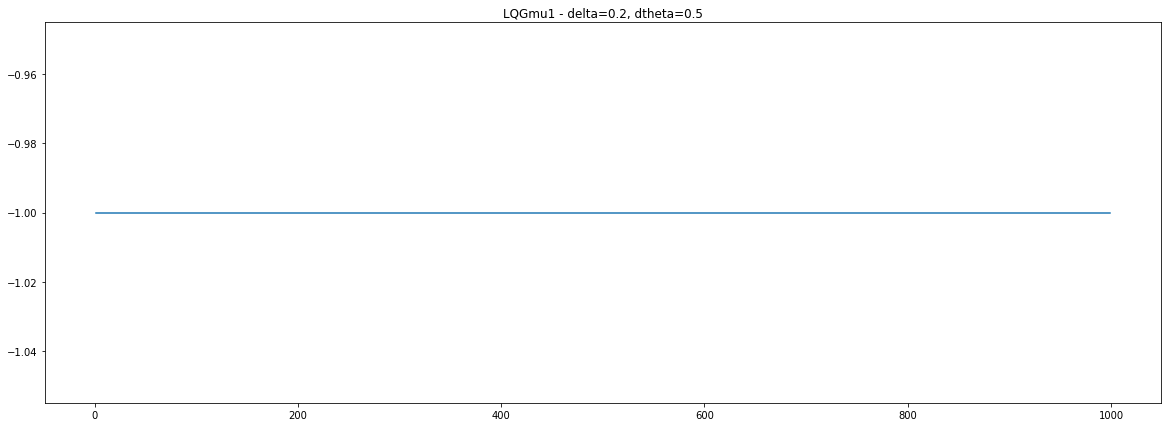

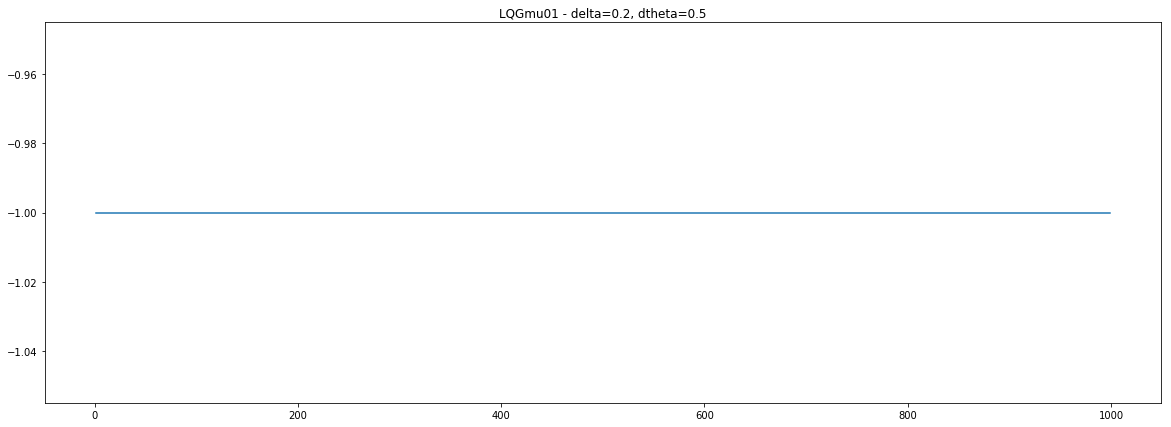

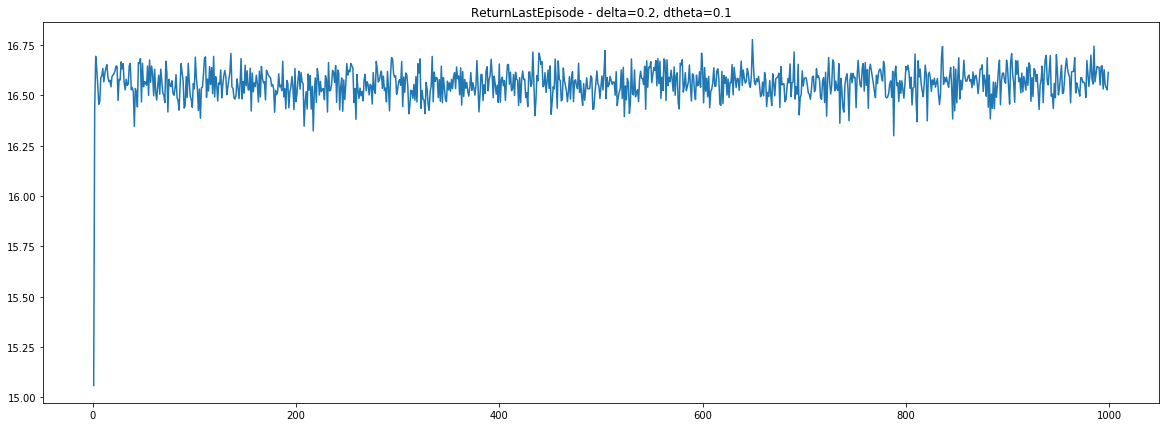

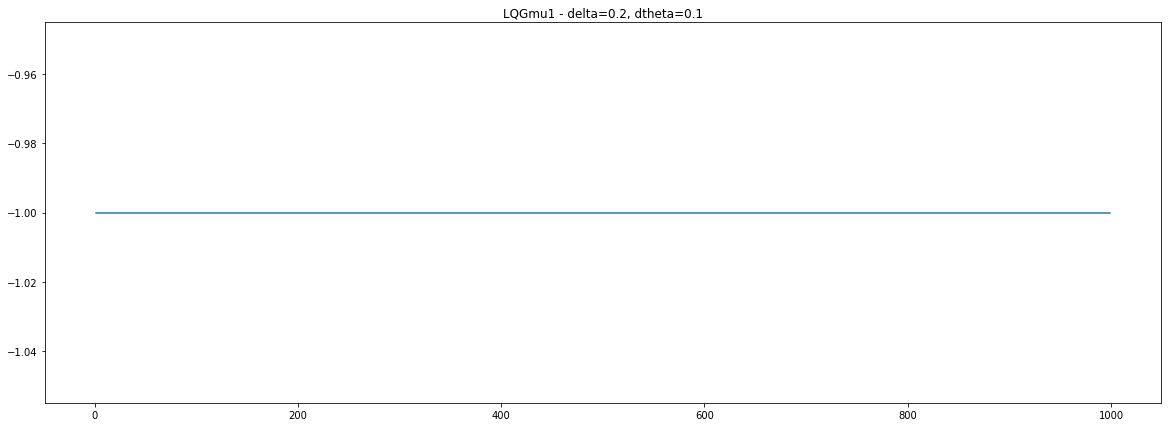

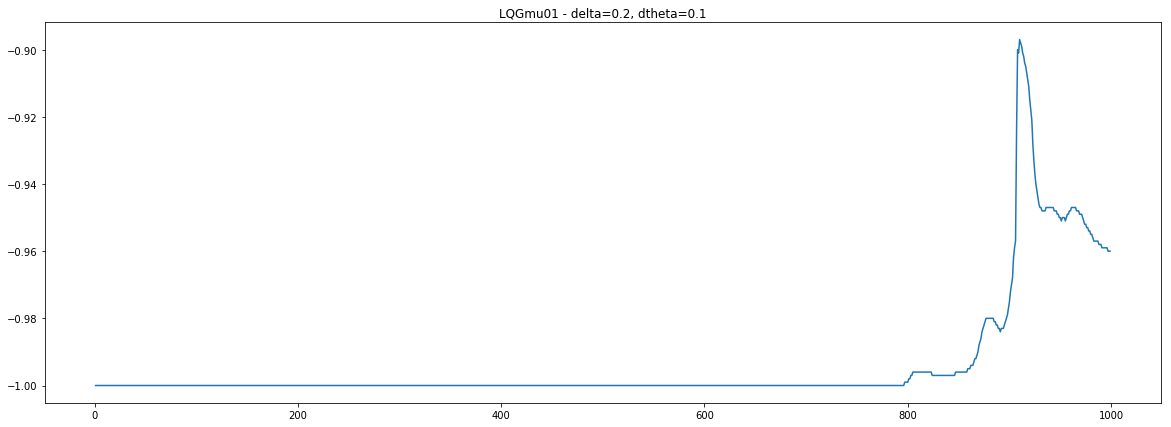

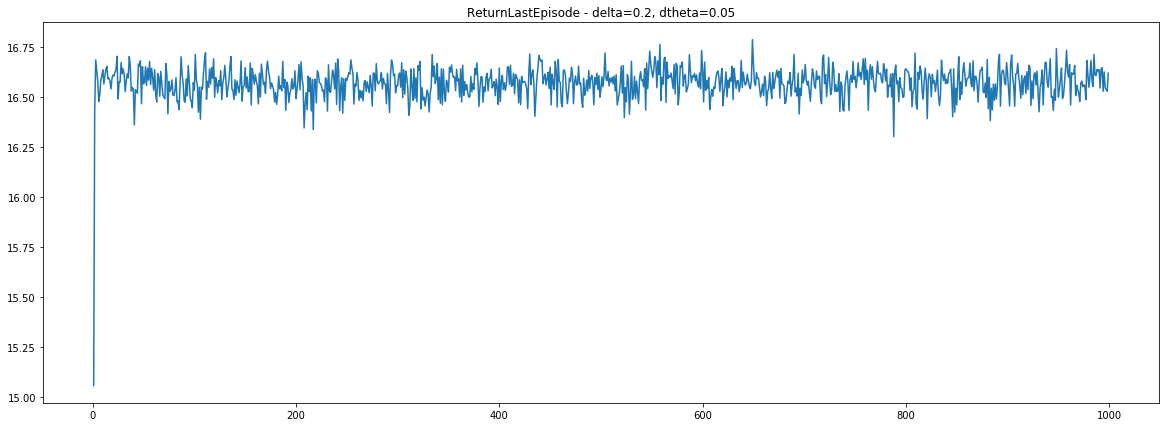

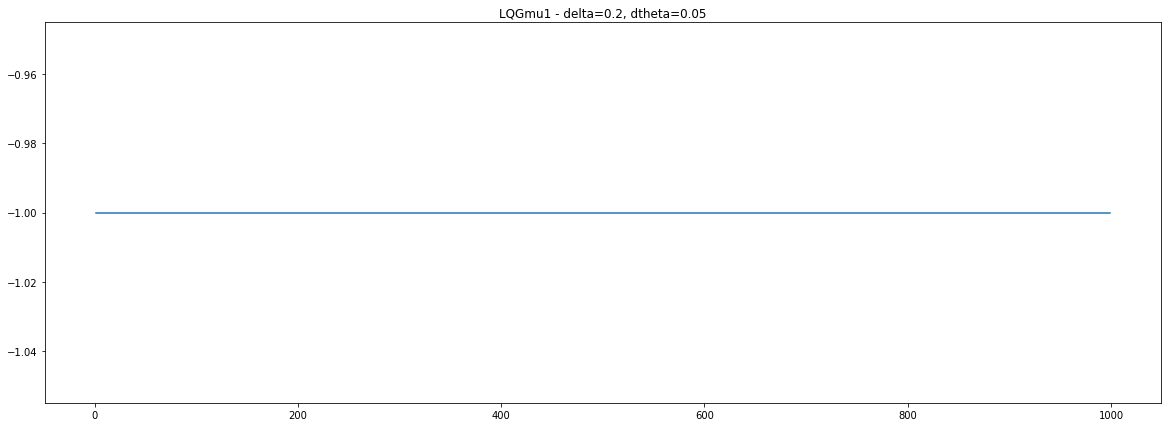

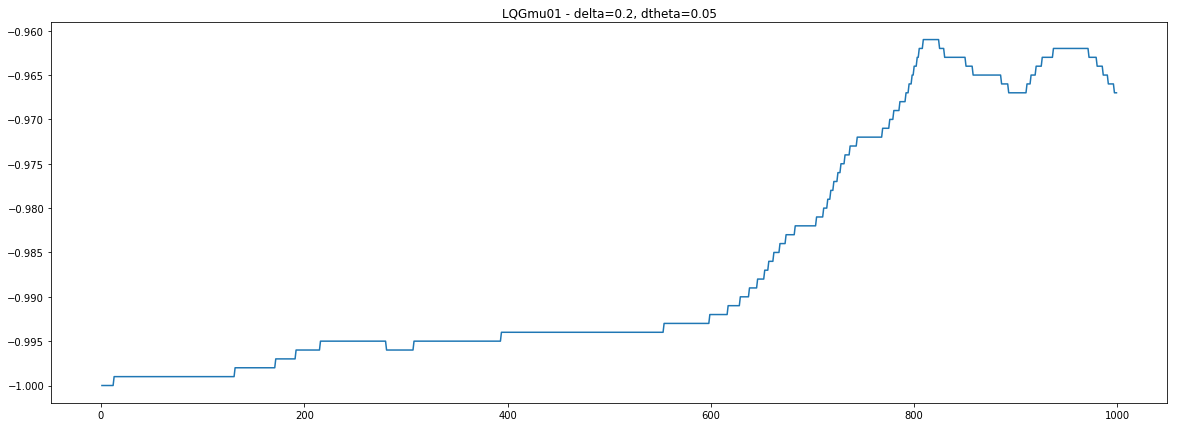

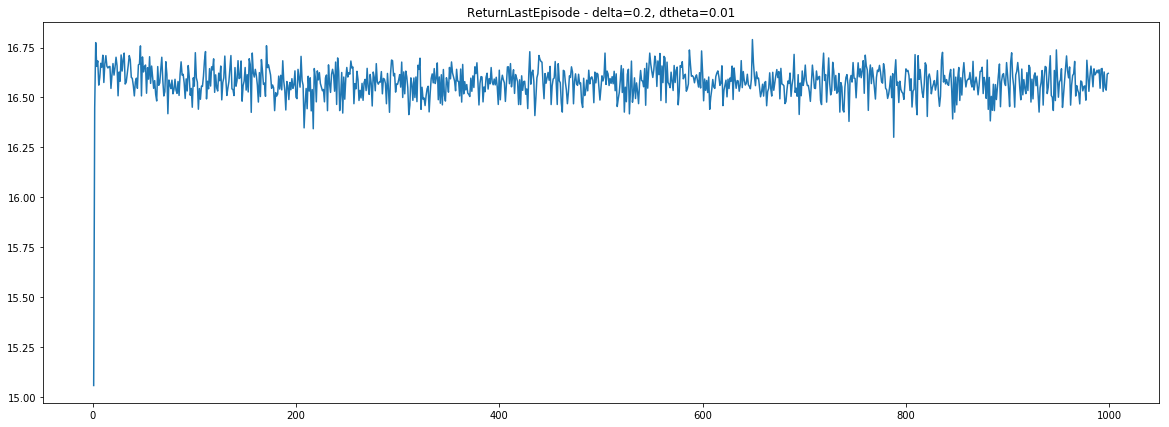

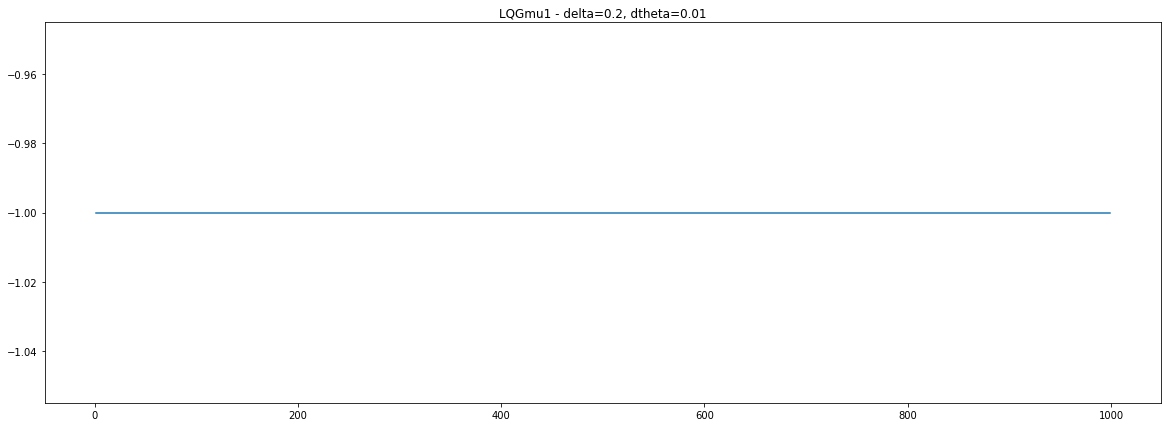

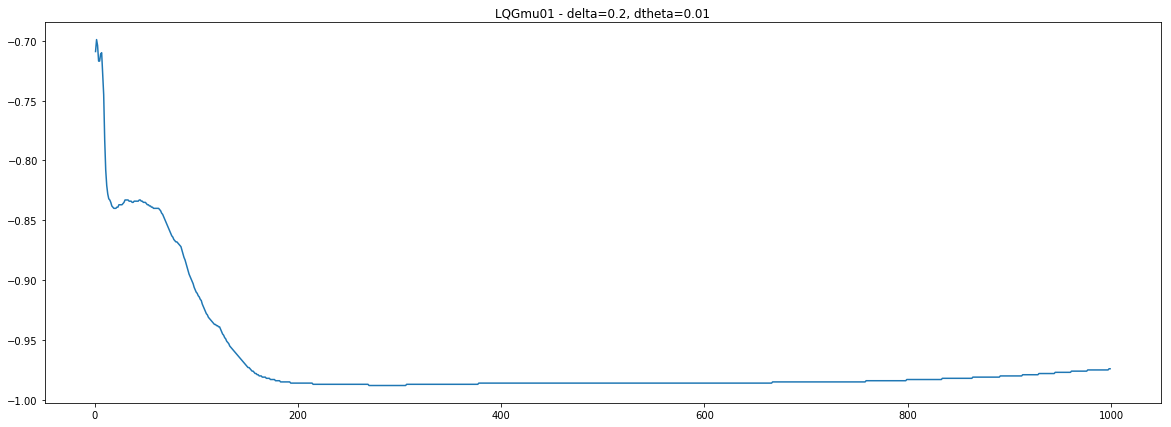

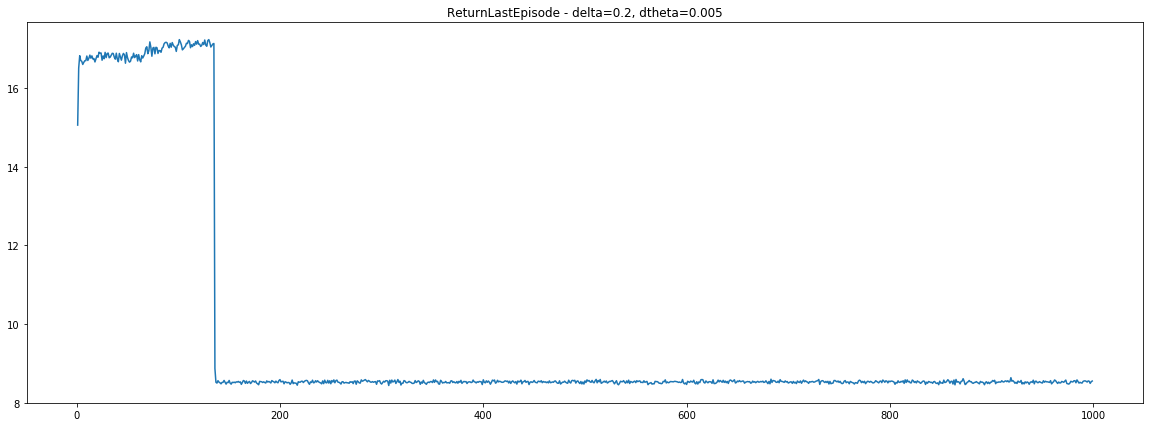

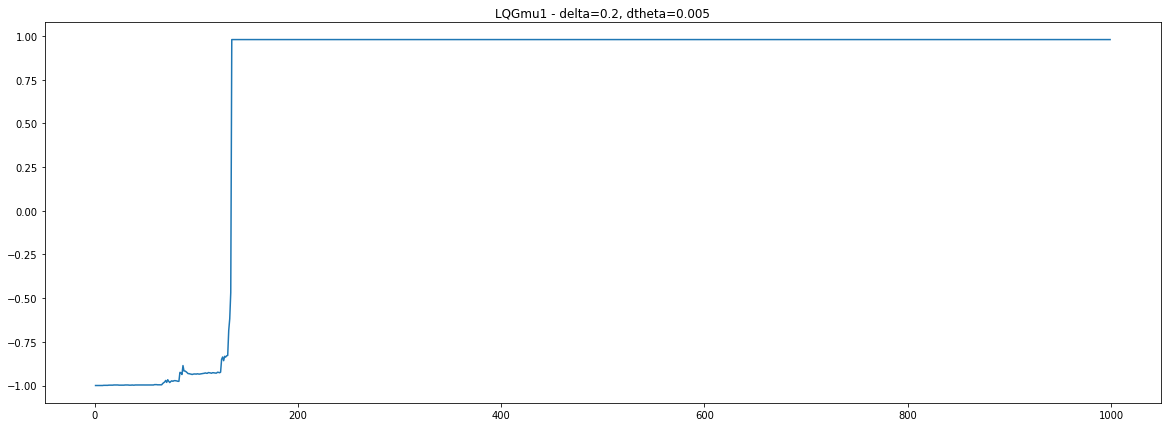

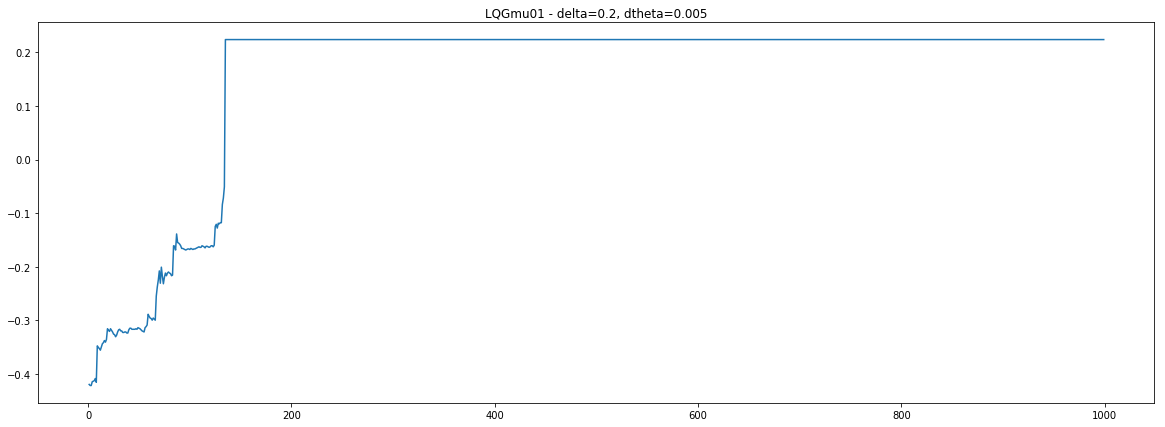

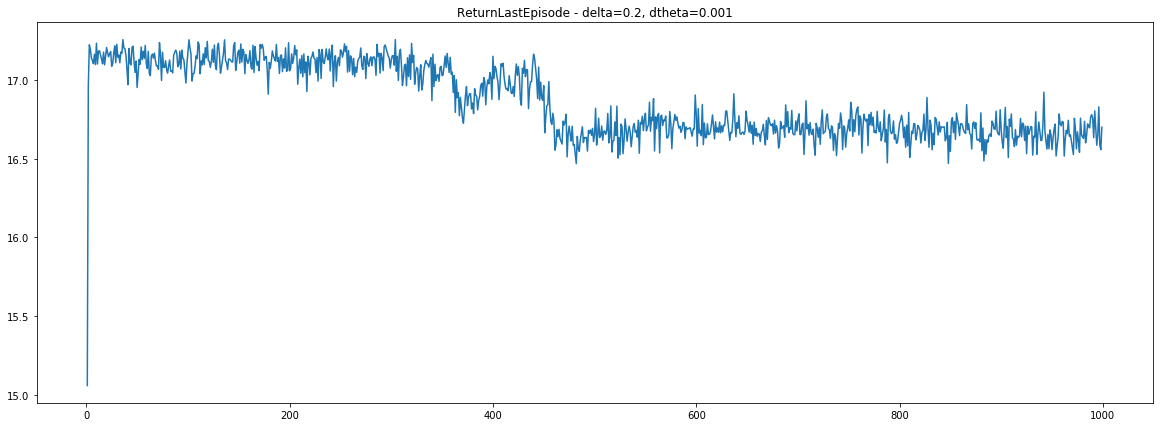

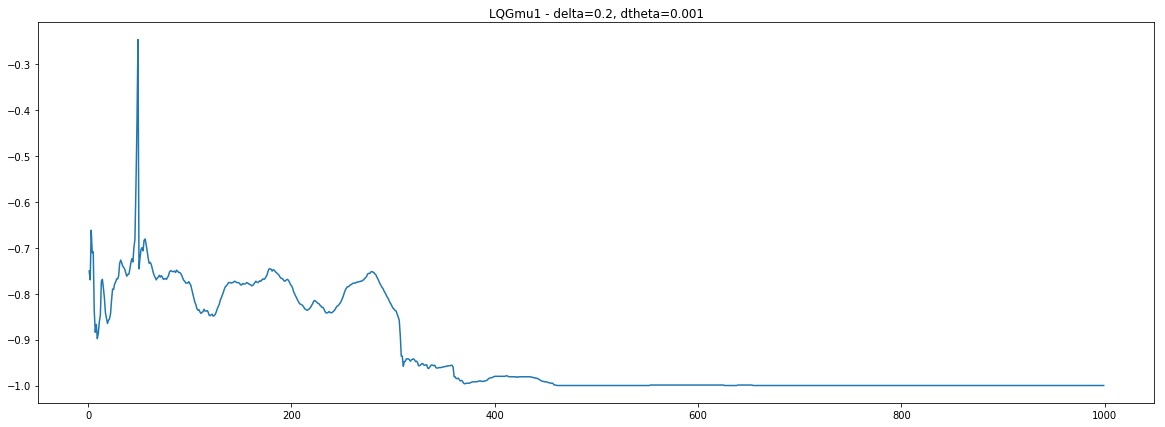

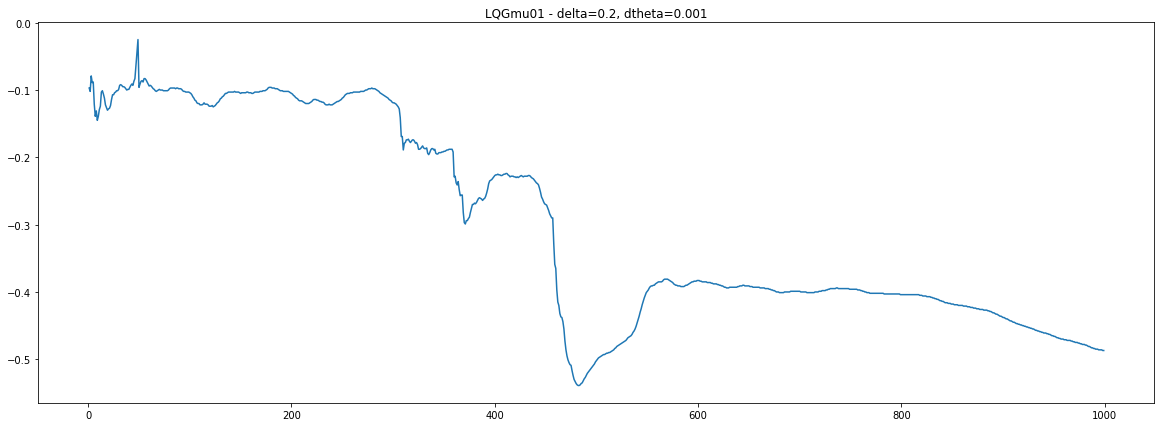

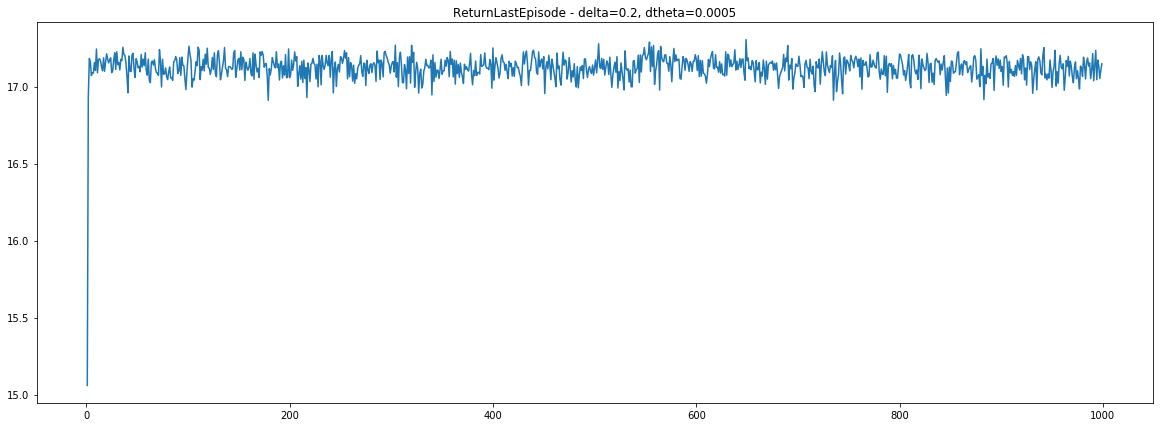

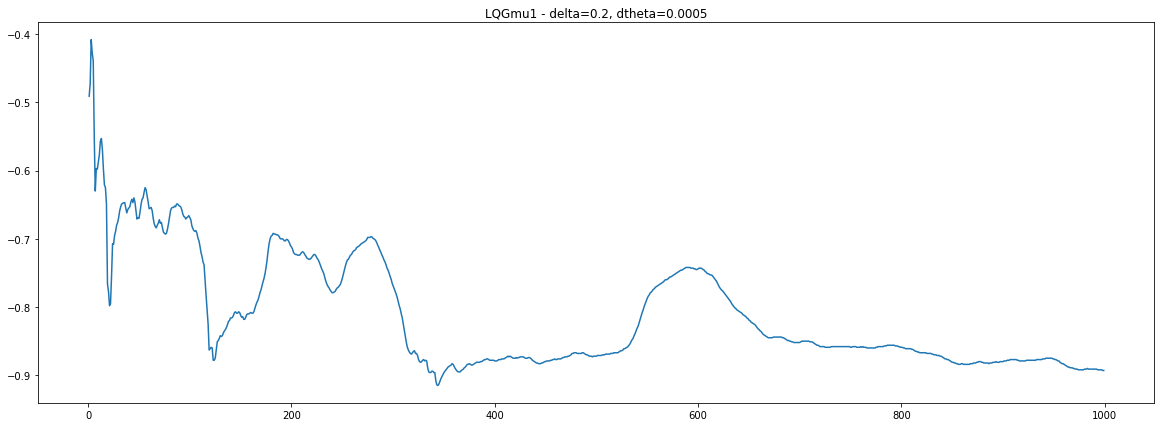

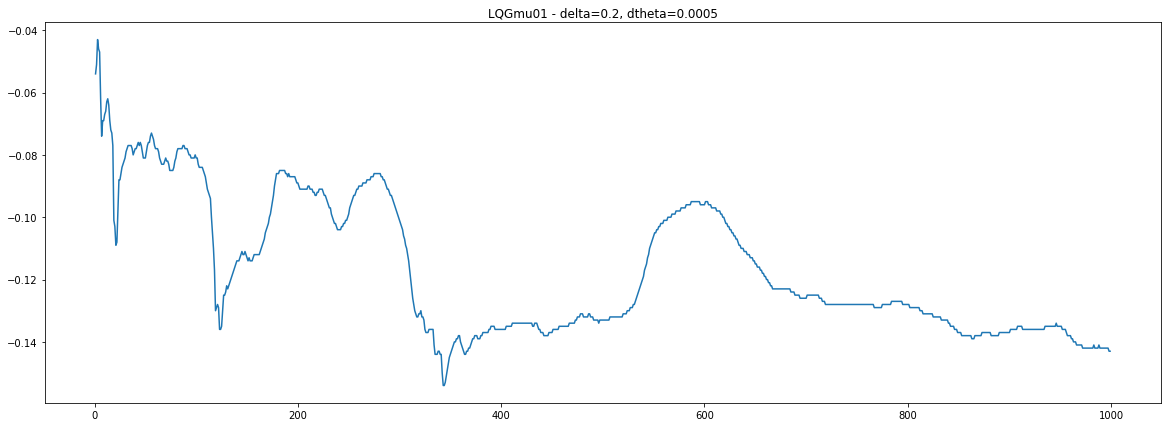

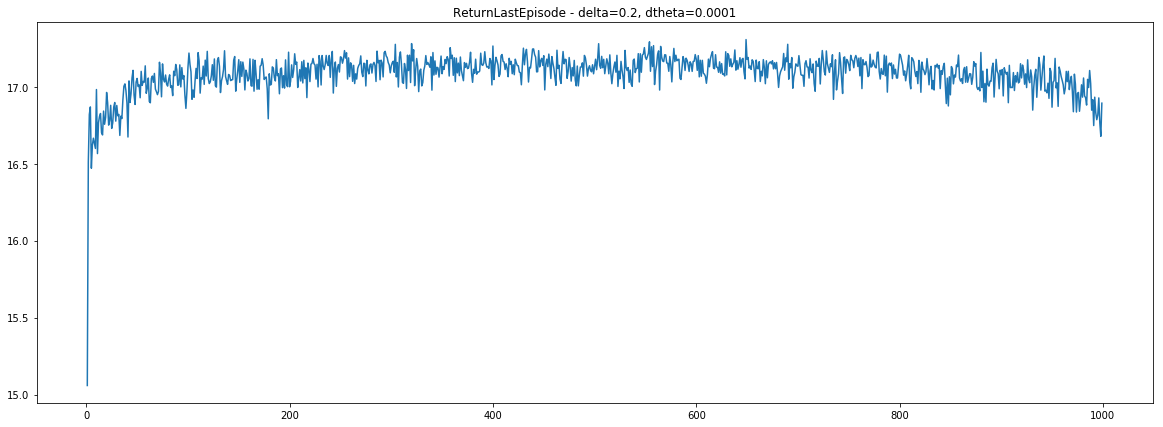

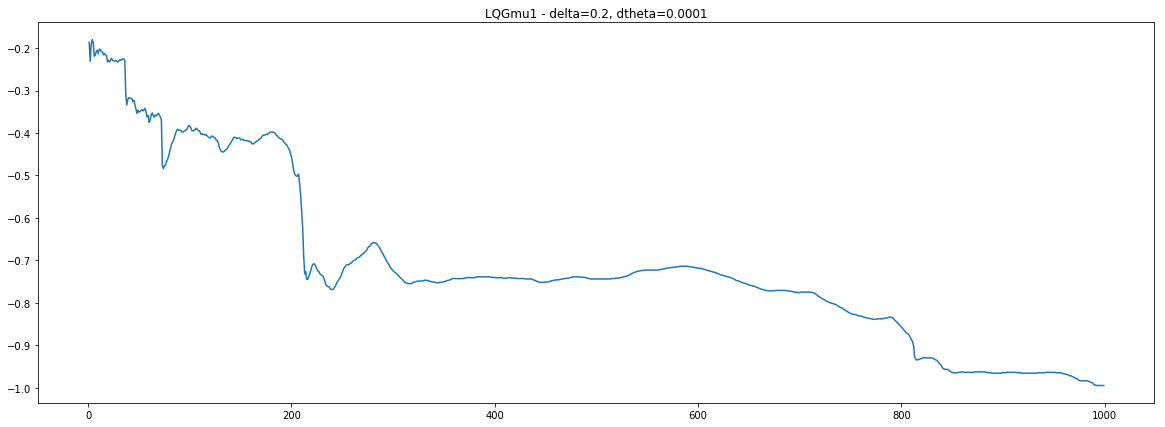

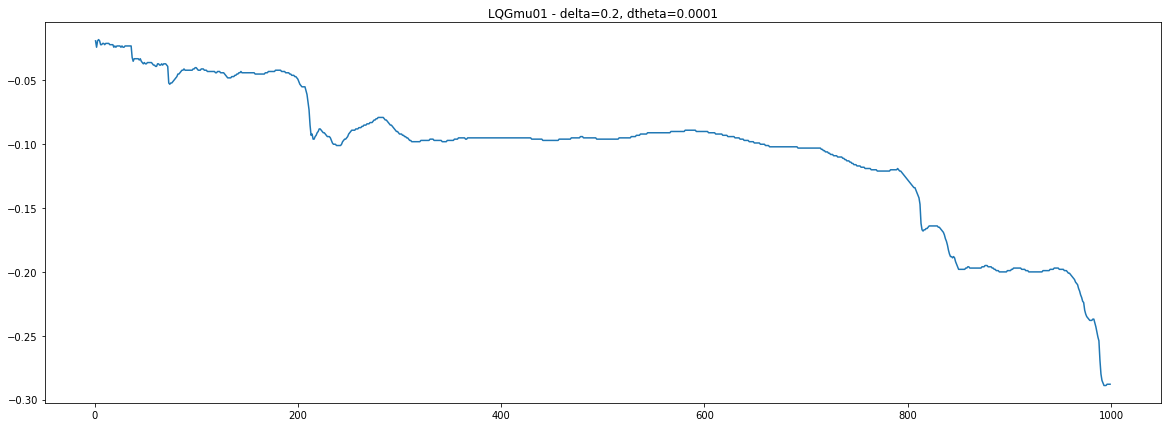

In [500]:
path ="./old_logs/which_dtheta/which_dtheta_fixed_*"
alpha = [1, 0.5, 0.1, 0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001]
delta = [0.2]
for d in delta:
    for a in alpha:
        substrings = ['delta=' + str(d), 'dtheta=' + str(a)] + ['seed=0'] # to check single seed
        dfs_list, filenames = read_csv(path, substrings, max_iters=None)
        tl = 'delta=' + str(d) + ', dtheta=' + str(a)
        fig1 = plot_ci(dfs_list, conf=0.95, key='ReturnLastEpisode', ylim=None, scale='Iteration', title=tl)
        fig2 = plot_ci(dfs_list, conf=0.95, key='LQGmu1', ylim=None, scale='Iteration', title=tl)
        fig3 = plot_ci(dfs_list, conf=0.95, key='LQGmu01', ylim=None, scale='Iteration', title=tl)


/home/lupol/.local/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1903: RuntimeWarning: invalid value encountered in greater
  cond0 = self._argcheck(*args) & (scale > 0) & (loc == loc)
/home/lupol/.local/lib/python3.5/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


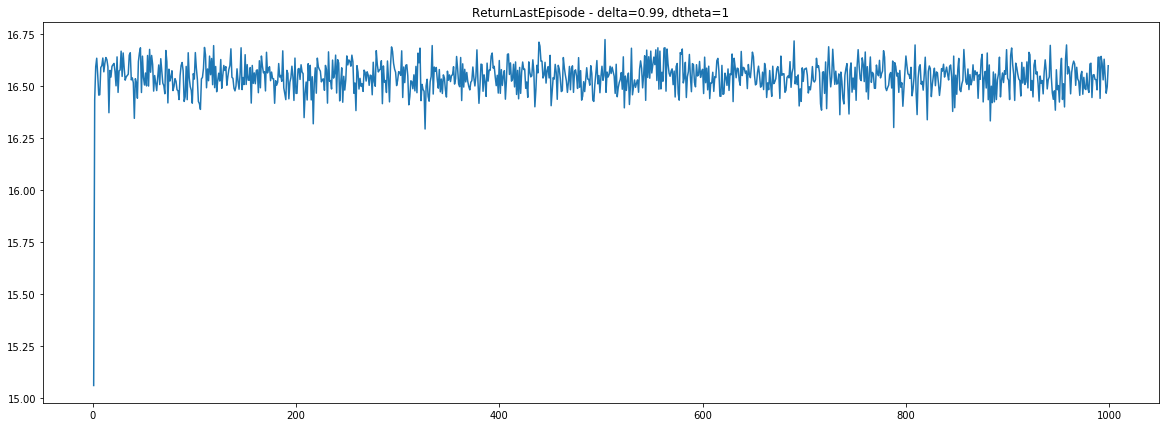

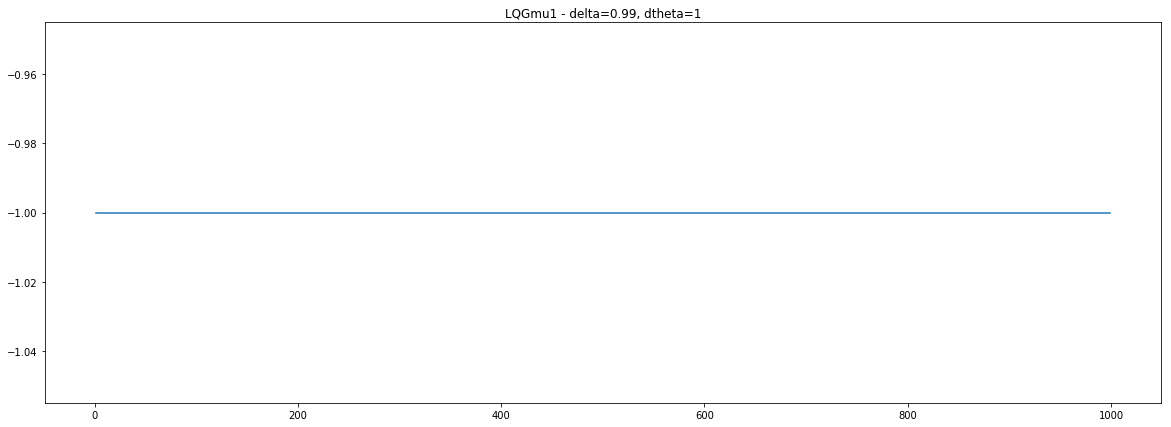

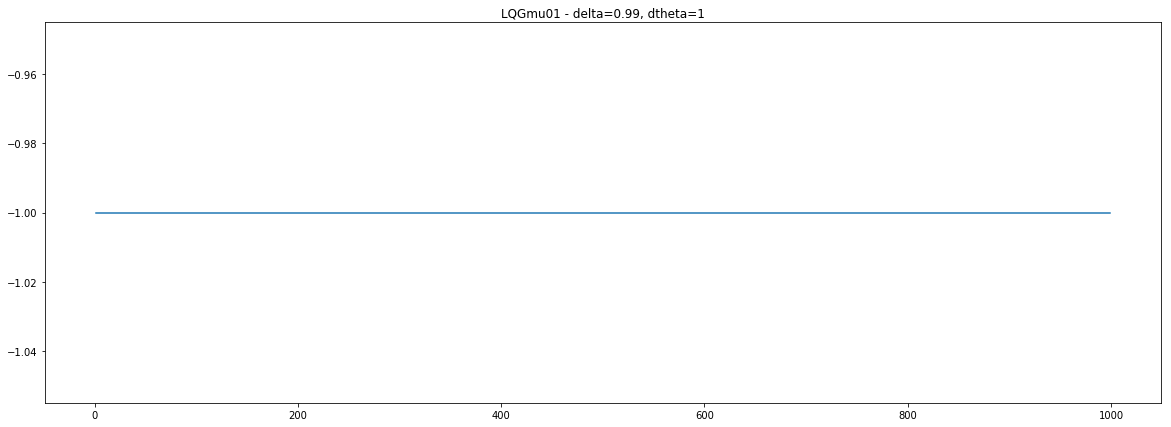

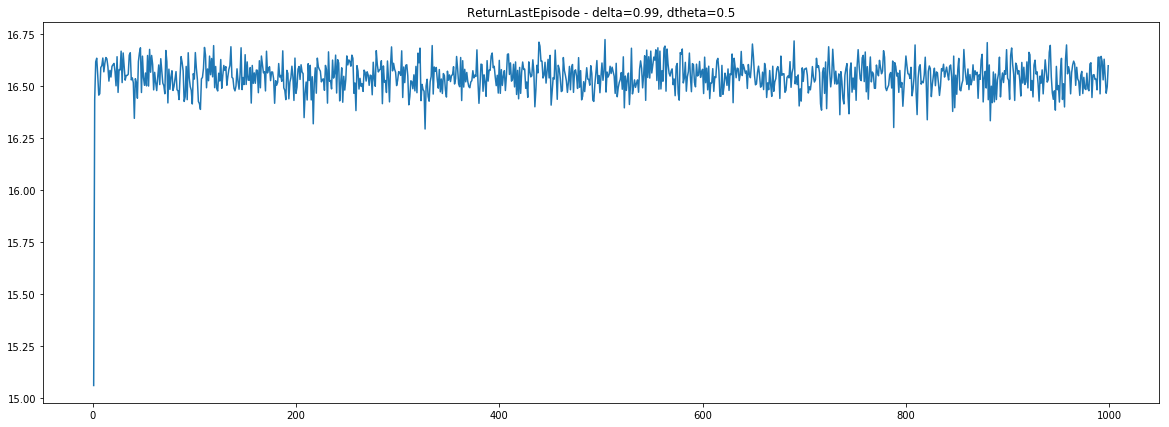

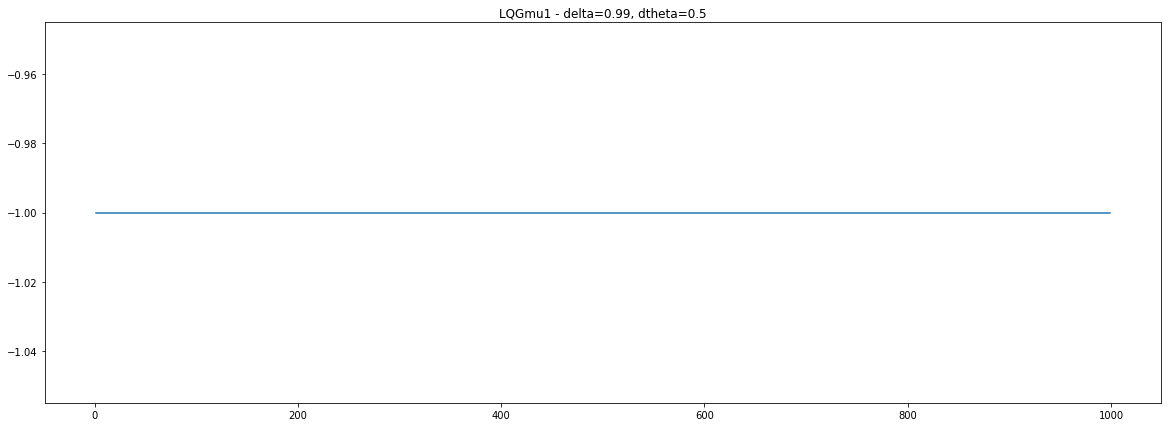

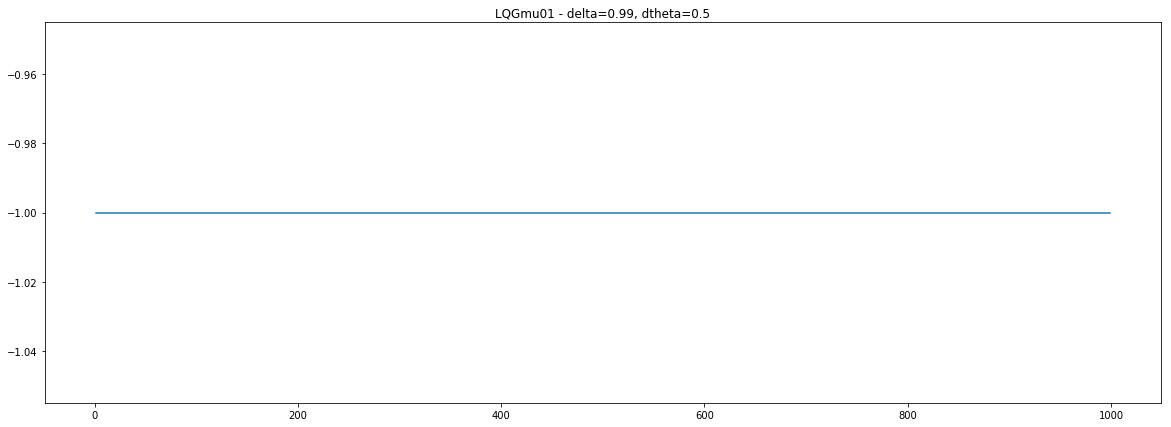

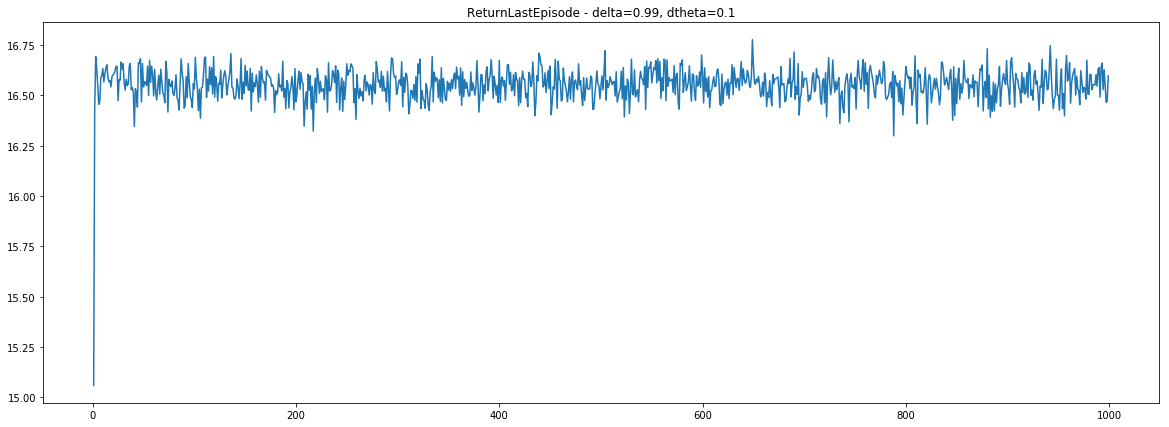

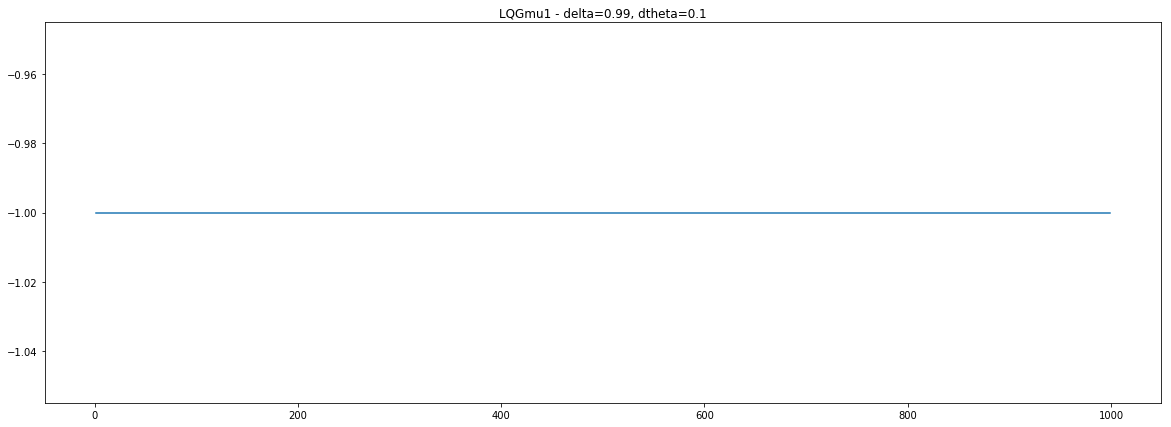

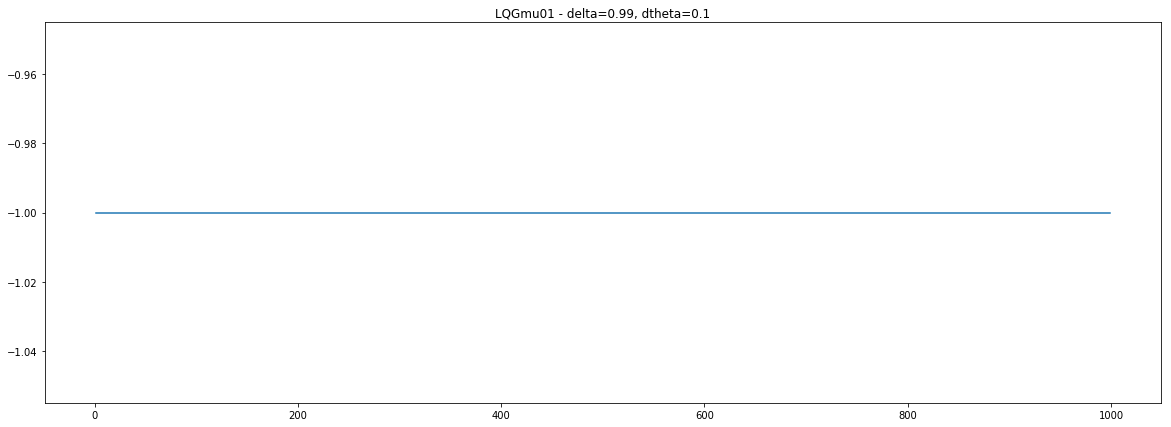

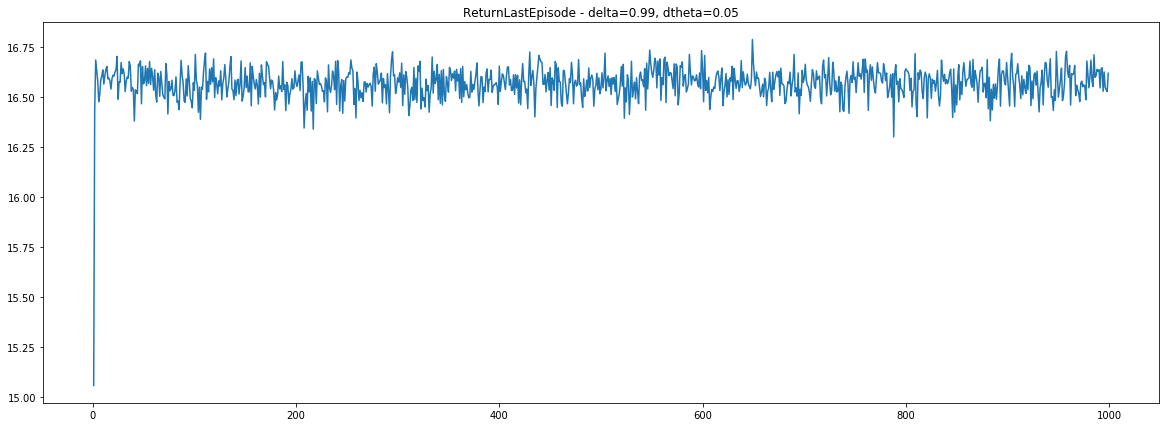

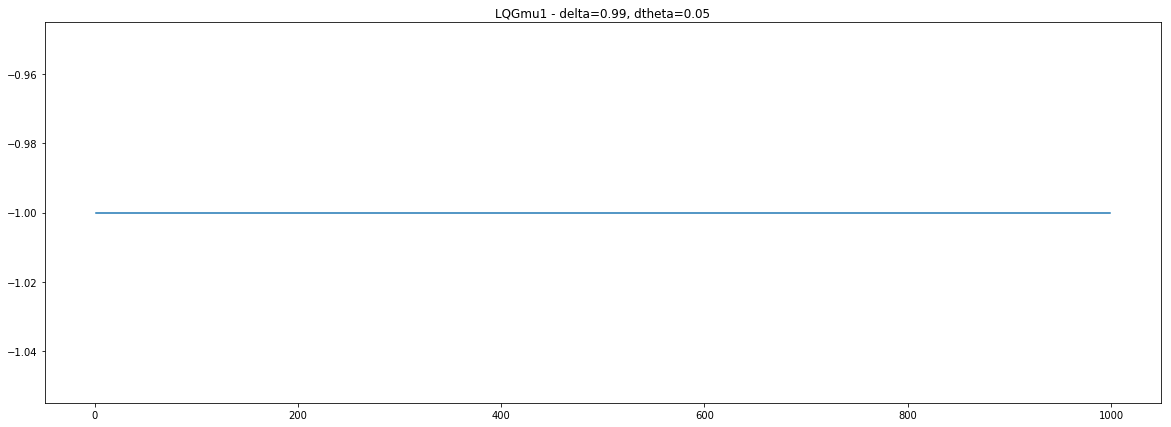

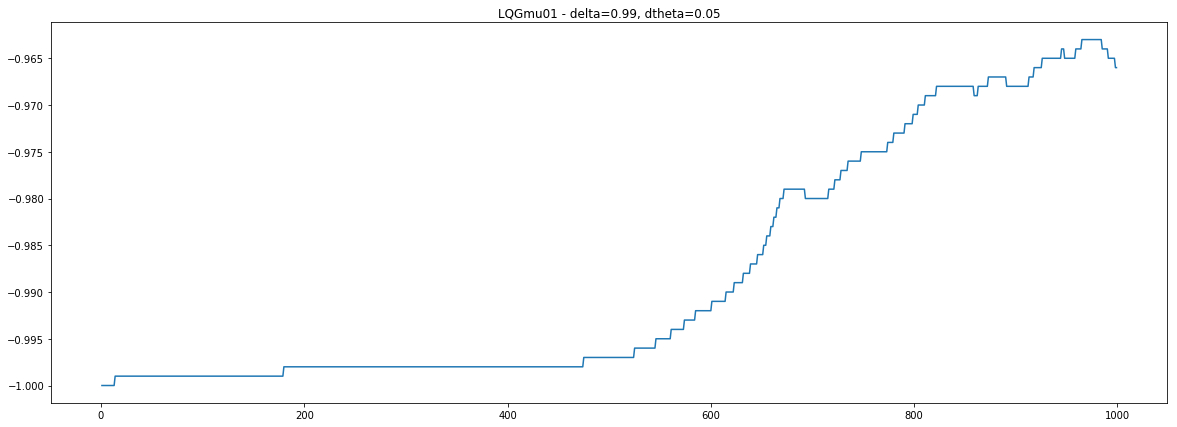

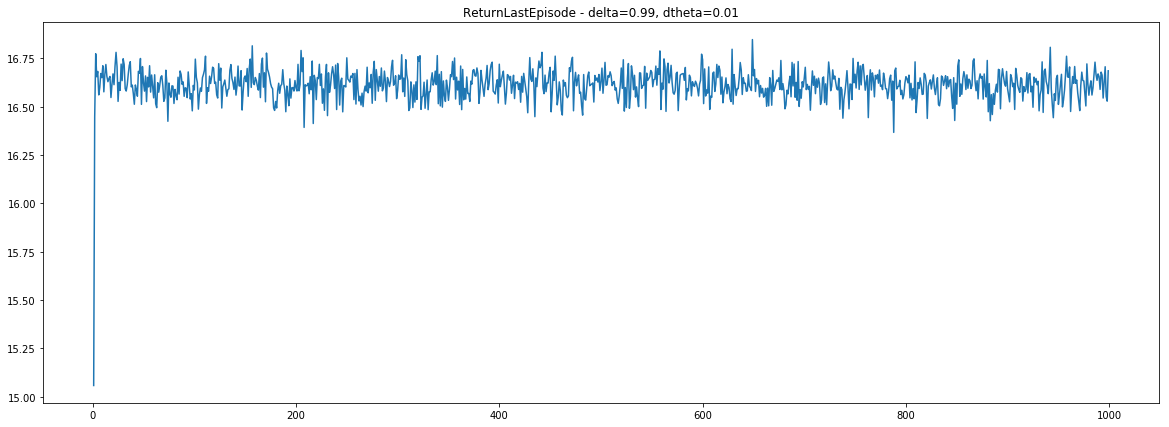

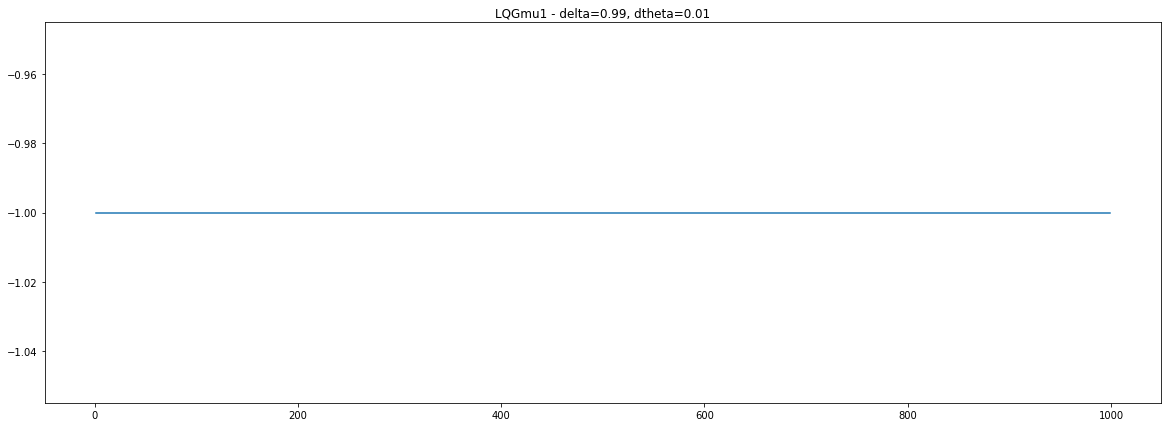

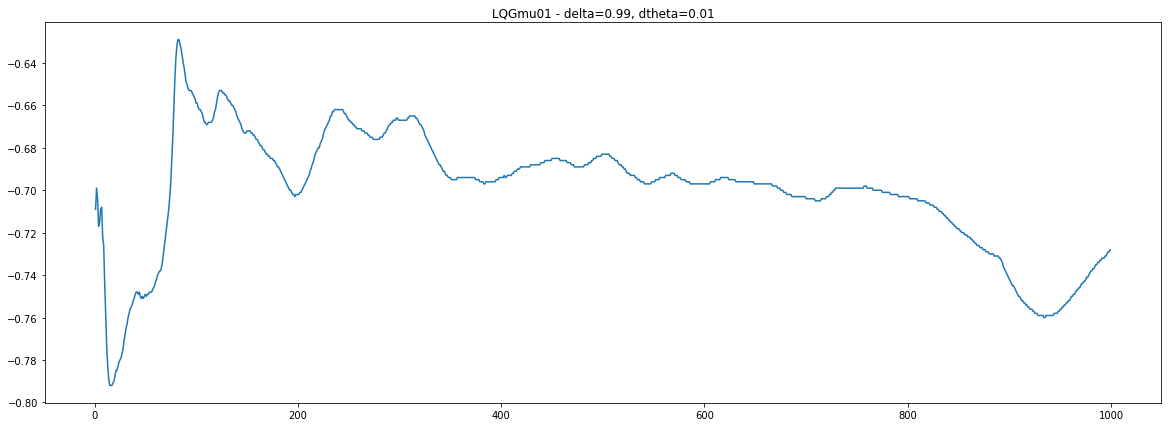

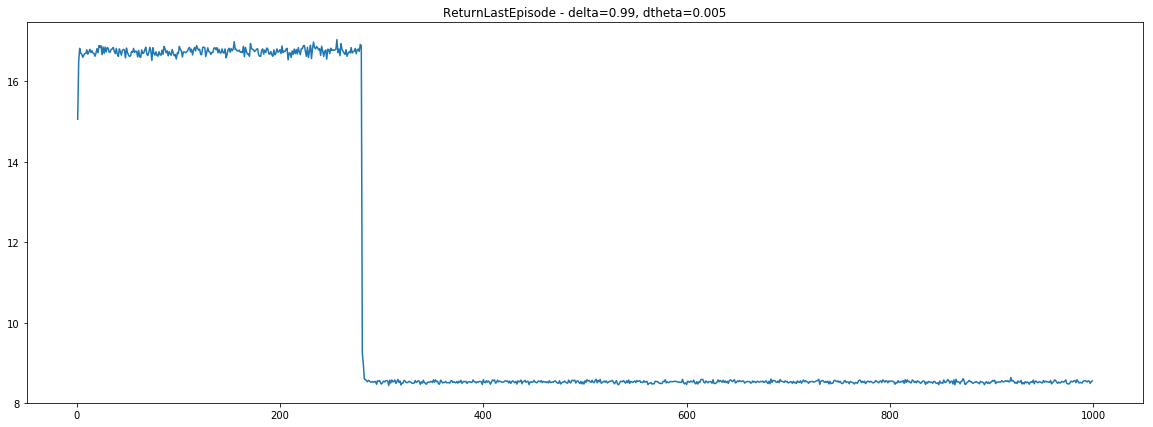

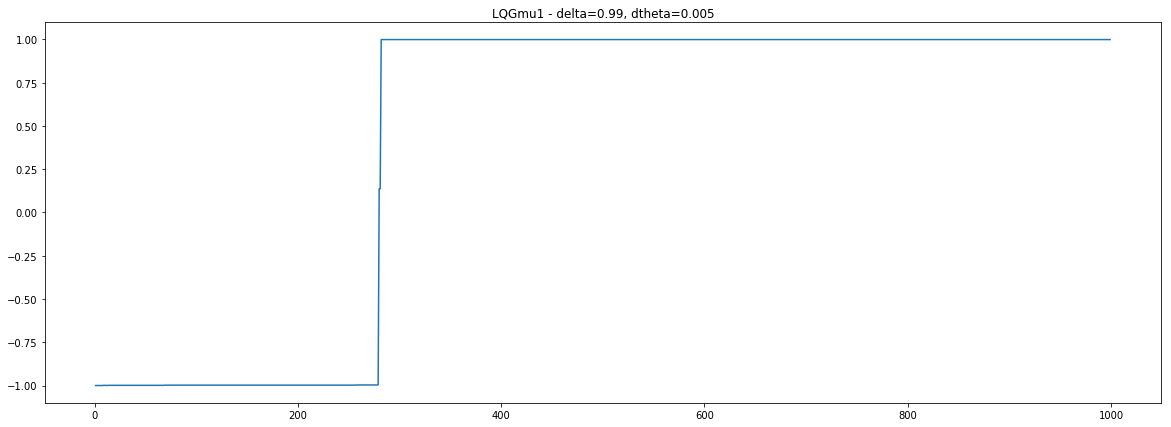

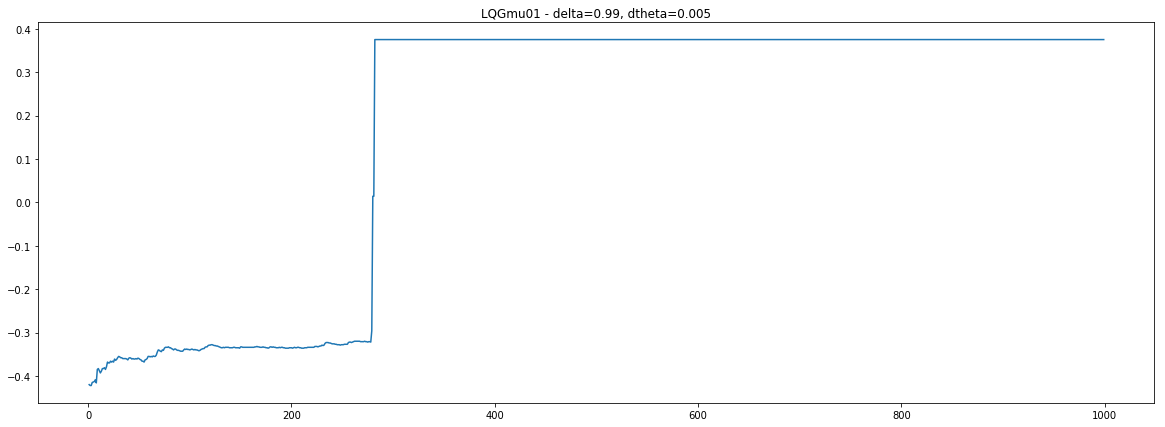

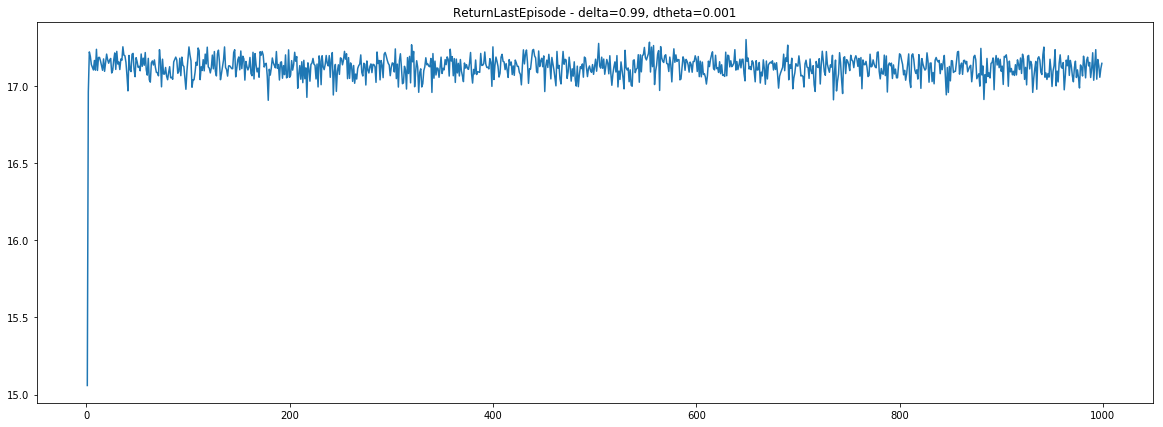

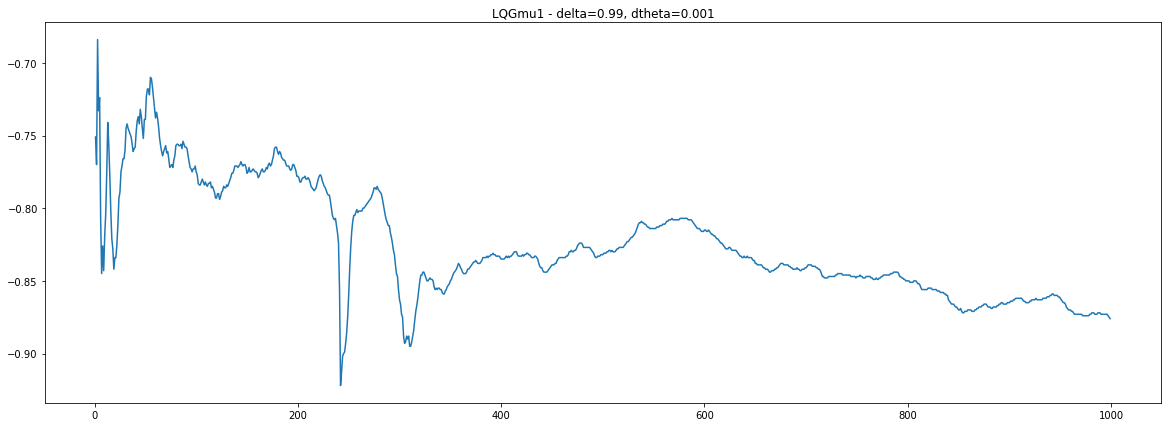

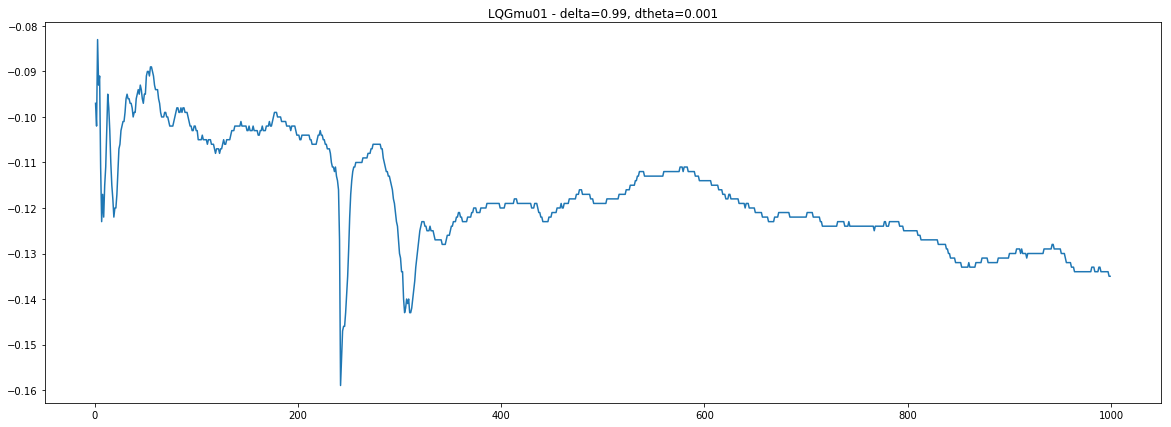

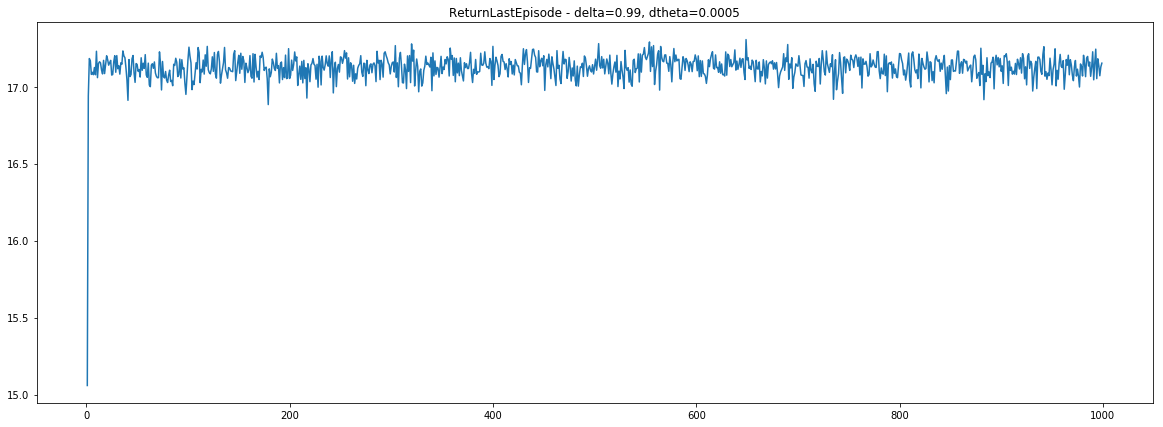

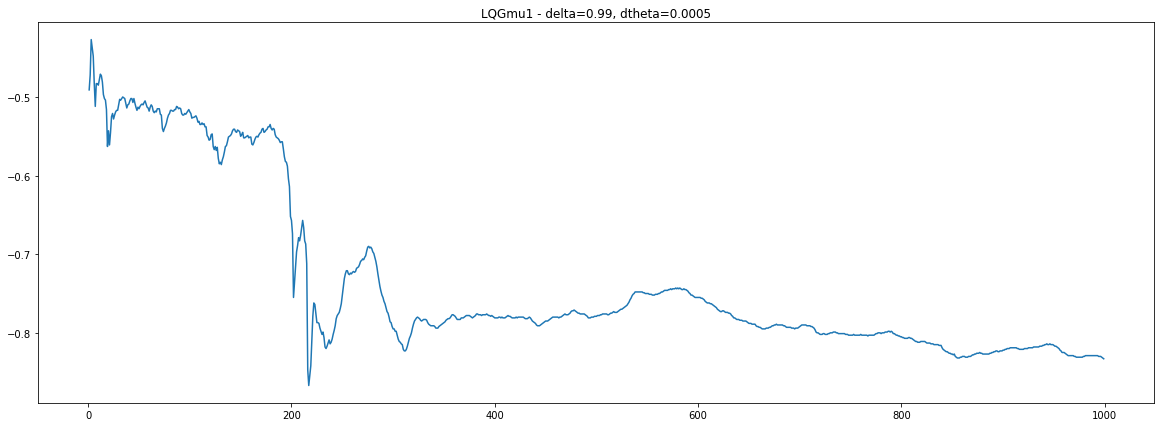

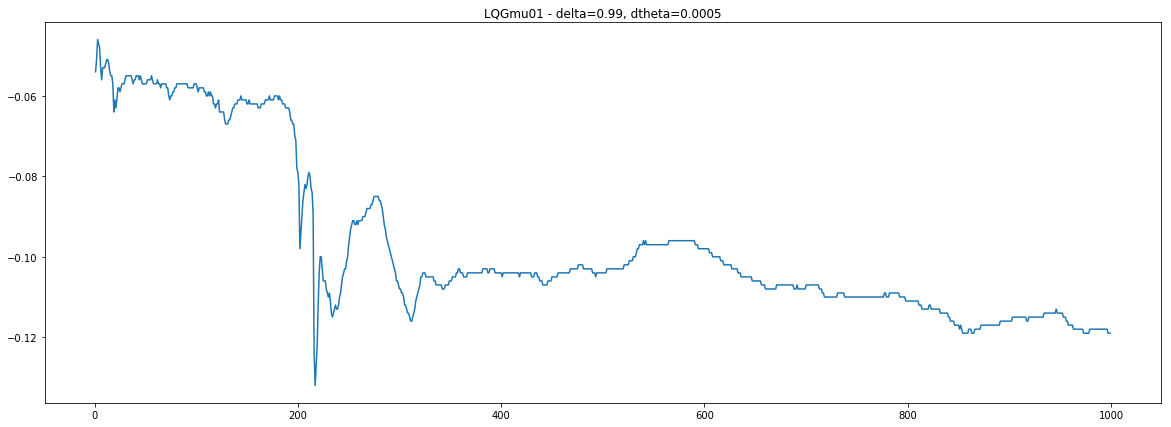

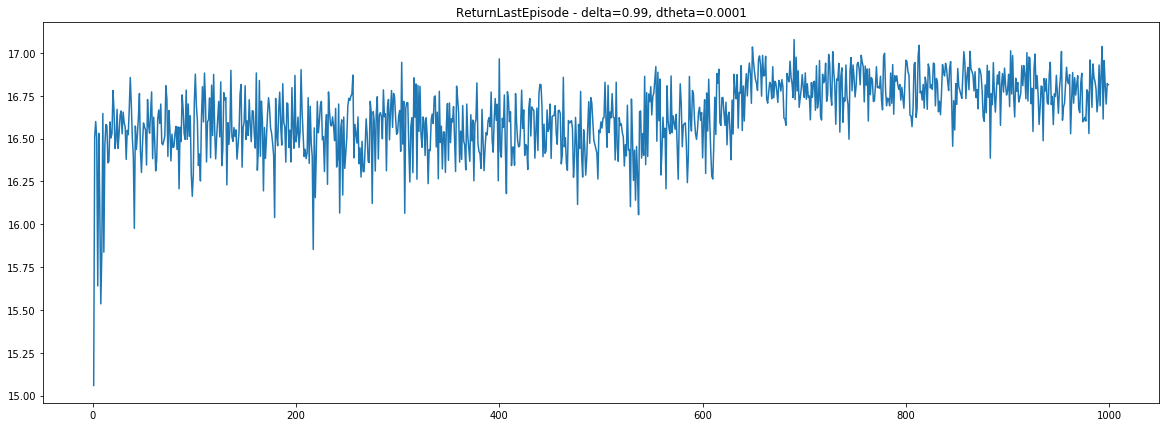

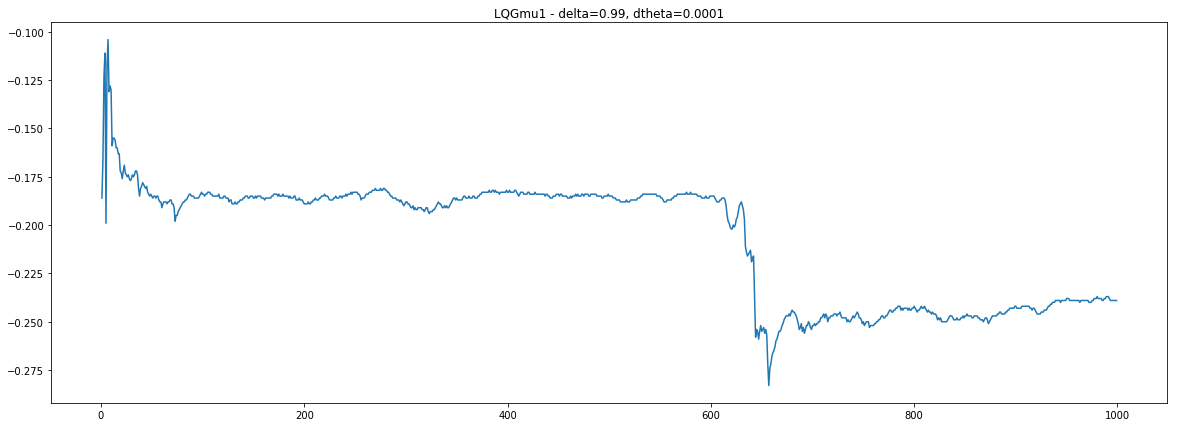

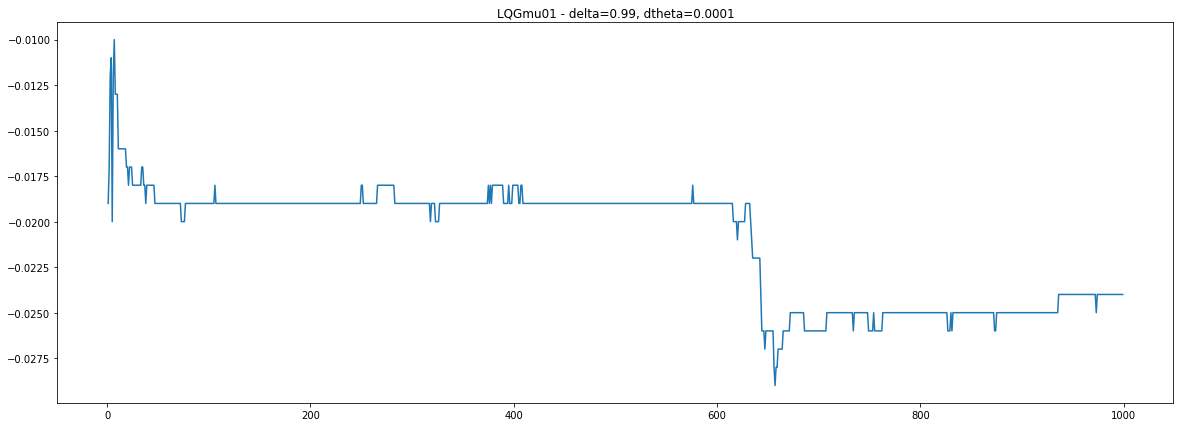

In [501]:
path ="./old_logs/which_dtheta/which_dtheta_fixed_*"
alpha = [1, 0.5, 0.1, 0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001]
delta = [0.99]
for d in delta:
    for a in alpha:
        substrings = ['delta=' + str(d), 'dtheta=' + str(a)] + ['seed=0'] # to check single seed
        dfs_list, filenames = read_csv(path, substrings, max_iters=None)
        tl = 'delta=' + str(d) + ', dtheta=' + str(a)
        fig1 = plot_ci(dfs_list, conf=0.95, key='ReturnLastEpisode', ylim=None, scale='Iteration', title=tl)
        fig2 = plot_ci(dfs_list, conf=0.95, key='LQGmu1', ylim=None, scale='Iteration', title=tl)
        fig3 = plot_ci(dfs_list, conf=0.95, key='LQGmu01', ylim=None, scale='Iteration', title=tl)


What is happening for big values of dtheta is that, depending on the seed, the gain goes to its borders in few steps and then stays there:
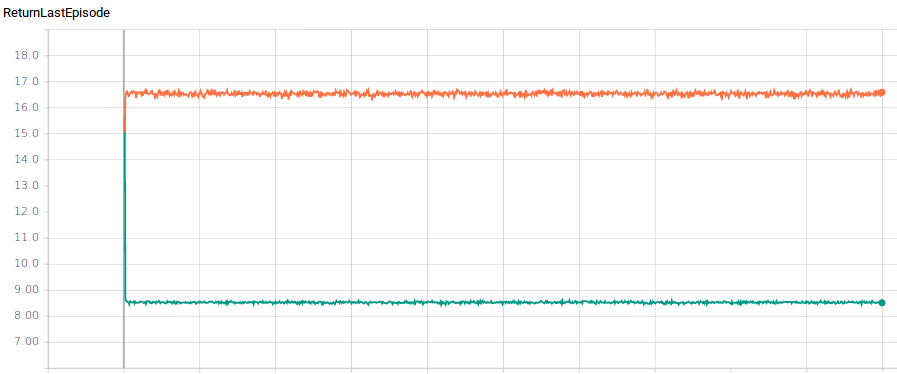
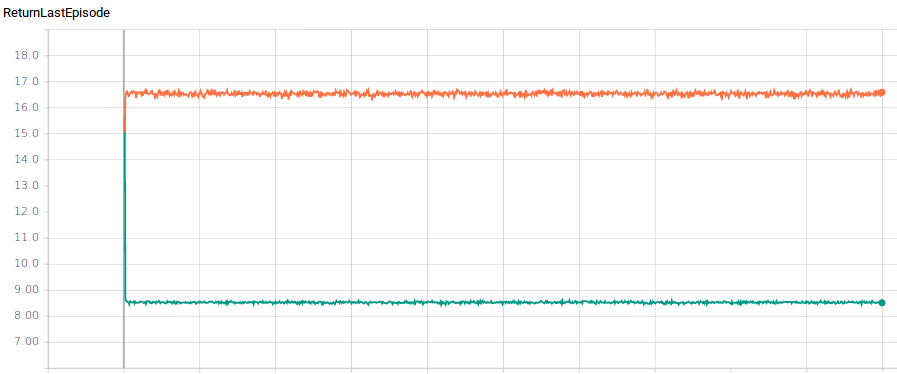
where delta=0.1., dtheta=1, orange=seed0, green=seed1

Insted, for smaller values of dtheta, we have more oscillations of mu and, subsequently, of the return, before falling into the vanishing gradients of one border.

Conclusions:
- we need a smart initialization at each start of the offline optimization
- the gradients make the gain change very qickly in one of the two directions, depending on the gradient. This may suggest that we should use smaller step size like dtheta=

# Step-size inversamente proporzionale alla norma del gradiente

In this experiments we try to tune the step-size alpha for the LQG problem when $$\alpha = \frac{dtheta}{||\nabla L||_2^2}$$
- dtheta = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
- delta = [0.1, 0.2, 0.99]
- seed = [0, 1, 2]

# Step-size setting misto

In this experiments we try to tune the step-size alpha for the LQG problem when:
$$\alpha = \begin{cases} \frac{dtheta}{||\nabla L||_2^2}, & \mbox{if } ||\nabla L||_2>1 \\ 1, & \mbox{if } ||\nabla L||_2\leq1 \end{cases}$$
- dtheta = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
- delta = [0.1, 0.2, 0.99]
- seed = [0, 1, 2]